<a href="https://colab.research.google.com/github/jhklee/lda_industry_classification/blob/main/LDA_industry_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os
drive.mount('/content/gdrive/')
os.chdir('/content/gdrive/MyDrive/research_projects/industry_classification')

Mounted at /content/gdrive/


### packages

In [ ]:
!pip install soyclustering

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords   
from nltk.stem.snowball import SnowballStemmer
import collections
import re
import string
import pandas as pd
import numpy as np
import unicodedata
import glob
import pickle
import os
import gc
from collections import Counter

import matplotlib.pyplot as plt
import plotly.express as px
import plotly

from soyclustering import SphericalKMeans
import scipy
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,HashingVectorizer
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras import optimizers

In [ ]:
import nltk
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet") 
nltk.download('stopwords')

# WRDS Compustat 2012-2015 and 10-K item 1 from web scrapping

In [ ]:
# This data is WRDS Compustat 
index_file = pd.read_csv('기업분류코드_정리본/01_Data/sicmerged.csv')
index_file.drop(21132,inplace=True)

In [ ]:
# This data is 10-K item 1 text data from web scrapping
comp_sic_data = pd.DataFrame(pd.read_pickle("기업분류코드_정리본/01_Data/new_comp_sic_merged.pickle"))
comp_sic_data

,company,fyear,business_part,sic,naics,exchange,gvkey,cik,ex,cusip,gind,gsector
0,1-800-FLOWERS.COM,2013,"1. business the company 1800flowers.com, inc....",5990.0,453110.0,NASDAQ,122519.0,1084869.0,NASDAQ,68243Q106,255020.0,25.0
1,1-800-FLOWERS.COM,2014,"1. business the company 1800flowers.com, inc....",5961.0,454111.0,NASDAQ,122519.0,1084869.0,NASDAQ,68243Q106,255020.0,25.0
2,1-800-FLOWERS.COM,2015,"1. business the company 1800flowers.com, inc....",5961.0,454111.0,NASDAQ,122519.0,1084869.0,NASDAQ,68243Q106,255020.0,25.0
3,1347 PROPERTY INS HLDGS INC,2014,1. business overview 1347 property insurance ...,6331.0,524126.0,6331,19528.0,1591890.0,6331,68244P107,403010.0,40.0
4,1347 PROPERTY INS HLDGS INC,2015,1. business overview 1347 property insurance ...,6331.0,524126.0,6331,19528.0,1591890.0,6331,68244P107,403010.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...
15406,iGlue Inc,2012,"1. business. as used in this annual report, w...",NaN,NaN,NaN,NaN,1133116.0,NaN,NaN,NaN,NaN
15407,iGlue Inc,2013,"1. business. as used in this annual report, w...",NaN,NaN,NaN,NaN,1133116.0,NaN,NaN,NaN,NaN
15408,iGlue Inc,2014,"1. business. as used in this annual report, w...",NaN,NaN,NaN,NaN,1133116.0,NaN,NaN,NaN,NaN
15409,iHeartCommunications Inc,2014,"1. business the company iheartcommunications,...",NaN,NaN,NYSE,NaN,739708.0,NYSE,NaN,NaN,NaN


In [ ]:
comp_sic_data['business_part'][0]

In [ ]:
def ff12_class(sic):
    industry_code = 10
    if ((100 <= sic <= 999) or (2000 <= sic <= 2399) or (2700 <= sic <= 2749) or (2770 <= sic <= 2799) or (3100 <= sic <= 3199) or (3940 <= sic <= 3989)):
        industry_code =  1 # Consumer Non Durable
    elif ((2500 <= sic <= 2519) or (2590 <= sic <= 2599) or (3630 <= sic <= 3659) or (3710 <= sic <= 3711) or 
          (3714 <= sic <= 3714) or (3716 <= sic <= 3716) or (3750 <= sic <= 3751) or (3792 <= sic <= 3792) or (3900 <= sic <= 3939) or (3990 <= sic <= 3999)):
        industry_code =  2 # Consumer Durable
    elif ((2520 <= sic <= 2589) or (2600 <= sic <= 2699) or (2750 <= sic <= 2769) or (3000 <= sic <= 3099) or 
          (3200 <= sic <= 3569) or (3580 <= sic <= 3621) or (3700 <= sic <= 3709) or (3712 <= sic <= 3713) or (3715 <= sic <= 3715) or 
          (3717 <= sic <= 3749) or (3752 <= sic <= 3791) or (3793 <= sic <= 3799) or (3830 <= sic <= 3839) or (3860 <= sic <= 3899)):
        industry_code = 3 # Manufacturing
    elif ((1200 <= sic <= 1399) or (2900 <= sic <= 2999)):
        industry_code = 4 # Energy
    elif ((2800 <= sic <= 2829) or (2840 <= sic <= 2899)):
        industry_code = 5 # Chemicals
    elif ((3570 <= sic <= 3579) or (3660 <= sic <= 3692) or (3694 <= sic <= 3699) or (3810 <= sic <= 3829) or (7370 <= sic <= 7379)):
        industry_code = 6 # Business equipment
    elif (4800 <= sic <= 4899):
        industry_code = 7 # Telecom
    elif (4900 <= sic <= 4949):
        industry_code = 8 # Utilities
    elif ((5000 <= sic <= 5999) or (7200 <= sic <= 7299) or (7600 <= sic <= 7699)):
        industry_code = 9 # Shops Wholesale (Retail)
    elif ((2830 <= sic <= 2839) or (3693 <= sic <= 3693) or (3840 <= sic <= 3859) or (8000 <= sic <= 8099)):
        industry_code = 10 # Healthcare, medical, drugs
    elif (6000 <= sic <= 6999):
        industry_code = 11 # Money Finance
    else:
        industry_code = 12 # Others
        
    return industry_code

comp_sic_data['ff12'] = comp_sic_data['sic'].apply(lambda sic: ff12_class(sic))

# countvectorize

## sckit learn vector

In [ ]:
# we used both sckit and gensim methods to make word vectors. 
lemma = nltk.wordnet.WordNetLemmatizer()
# we extract nouns from the text raw data
is_noun = lambda pos: pos[:2] == 'NN'
st = PorterStemmer()

i=0
# tokenize the raw text data using nltk
def tokenize(text):
    global i
    if (i%100 == 0):
        print(i, end=' // ')
        gc.collect()
    tokens = nltk.word_tokenize(text.lower())
    # use tokens longer than 3 alphabets
    token_after = [w for w in tokens if (w.isalpha() and len(w) > 2)] 
    # token_after_geo = [w for w in token_after if (not w in stopwords.words('english'))]
    # we use noun tokens for the vectorization preocces
    stems = [lemma.lemmatize(word) for (word, pos) in nltk.pos_tag(token_after) if is_noun(pos)]
    i += 1
    
    del tokens, token_after
    return stems

# if the words come up more than 20% of the entire raw text data we do not consider. 
count_vect = CountVectorizer(max_df = 0.20, max_features=2000, tokenizer=tokenize, stop_words='english', lowercase=True, analyzer='word') 

In [ ]:
# takes about 2 hours
X_train_counts = count_vect.fit_transform(comp_sic_data['business_part'])

In [ ]:
# save the results in depositary
with open('기업분류코드_정리본/02_Result/X_train_counts_new_2000_chan_0420.pickle', 'rb') as f:
    X_train_counts = pickle.load(f)

In [ ]:
# check the shape of the vector. 
X_train_counts.toarray().shape

(15411, 2000)

In [ ]:
# Convert a matrix in scipy.sparse format into a streaming Gensim corpus.
test_1=gensim.matutils.Sparse2Corpus(X_train_counts, documents_columns=True)

## gensim vector

In [ ]:
comp_sic_data

In [ ]:
business_df = comp_sic_data
business_df['business_part']

In [ ]:
lemma = nltk.wordnet.WordNetLemmatizer()
is_noun = lambda pos: pos[:2] == 'NN'
st = PorterStemmer()

In [ ]:
stems=[]
for text in business_df['business_part']:

  tokens = nltk.word_tokenize(text.lower())
  # use tokens longer than 3 alphabets
  token_after = [w for w in tokens if (w.isalpha() and len(w) > 2)]
  # we use noun tokens for the vectorization preocces
  stems.append([lemma.lemmatize(word) for (word, pos) in nltk.pos_tag(token_after) if is_noun(pos)])
  del tokens, token_after

In [ ]:
pd.Series(stems)

0        [business, company, world, florist, gift, shop...
1        [business, company, world, florist, gift, shop...
2        [business, company, subsidiary, company, world...
3        [business, overview, property, insurance, hold...
4        [business, overview, property, insurance, hold...
                               ...                        
15406    [business, report, company, company, company, ...
15407    [business, report, company, company, company, ...
15408    [business, report, company, company, company, ...
15409    [business, company, company, corporation, shar...
15410    [business, company, company, corporation, shar...
Length: 15411, dtype: object

In [ ]:
business_part_gensim=pd.Series(stems)

In [ ]:
# save the data
# business_part_gensim.to_csv('results/business_part_gensim_tokenized.csv')

# with open('results/business_part_gensim_tokenized.pickle', 'wb') as f:
#   pickle.dump(X_train_counts,f)

In [ ]:
# bring the data from repositary
business_part_gensim=pd.read_csv('results/business_part_gensim_tokenized.csv')
business_part_gensim

,Unnamed: 0,0
0,0,"['business', 'company', 'world', 'florist', 'g..."
1,1,"['business', 'company', 'world', 'florist', 'g..."
2,2,"['business', 'company', 'subsidiary', 'company..."
3,3,"['business', 'overview', 'property', 'insuranc..."
4,4,"['business', 'overview', 'property', 'insuranc..."
...,...,...
15406,15406,"['business', 'report', 'company', 'company', '..."
15407,15407,"['business', 'report', 'company', 'company', '..."
15408,15408,"['business', 'report', 'company', 'company', '..."
15409,15409,"['business', 'company', 'company', 'corporatio..."


In [ ]:
temp3=business_part_gensim['0'].apply(eval)

In [ ]:
from gensim import corpora

tokenized_doc = temp3
dictionary = corpora.Dictionary(tokenized_doc)
# if the words come up more than 20% of the entire raw text data we do not consider. 
dictionary.filter_extremes(no_below=1, no_above=0.2, keep_n=2000)

In [ ]:
# we need to change the encoded words into real words
dictionary_dict=dictionary.token2id
dictionary_list=dictionary_dict.keys()
len(dictionary_list)

# save the real word list in depositary
# pd.Series(dictionary_list).to_csv('results/dictionary_list.csv')

2000

In [ ]:
# vectorization precess
corpus = [dictionary.doc2bow(text) for text in tokenized_doc]
print(corpus[1]) # 수행된 결과에서 두번째 뉴스 출력. 첫번째 문서의 인덱스는 0

[(0, 1), (1, 3), (2, 1), (3, 2), (4, 2), (6, 1), (7, 1), (8, 1), (9, 2), (10, 4), (11, 1), (12, 3), (13, 1), (14, 1), (15, 1), (16, 1), (17, 4), (18, 1), (19, 2), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 5), (30, 2), (32, 3), (33, 2), (34, 1), (35, 1), (36, 3), (37, 8), (38, 1), (39, 1), (40, 1), (41, 2), (43, 1), (44, 1), (45, 5), (46, 1), (47, 1), (49, 1), (50, 17), (51, 1), (52, 55), (54, 2), (56, 8), (57, 2), (58, 1), (59, 1), (60, 1), (61, 1), (62, 2), (63, 3), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (72, 1), (73, 1), (74, 2), (75, 5), (76, 2), (79, 3), (80, 1), (81, 1), (82, 1), (83, 5), (84, 1), (86, 2), (87, 1), (88, 1), (89, 1), (90, 1), (91, 9), (92, 3), (93, 1), (94, 1), (95, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 4), (108, 1), (109, 1), (110, 1), (111, 1), (112, 1), (113, 2), (115, 1), (116, 1), (117, 2), (118, 1), (119, 1), (120, 1), (121, 1), (122, 1), (12

In [ ]:
from gensim import corpora
from gensim import models
import gensim
gensim_countvec=gensim.matutils.corpus2dense(corpus,2000).T
gensim_countvec.shape

/usr/local/lib/python3.7/dist-packages/gensim/matutils.py:502: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



(15411, 2000)

In [ ]:
# the word vector from gensim
gensim_countvec_df=pd.DataFrame(gensim_countvec,columns=dictionary_list)
gensim_countvec_df

,adherence,advisor,alliance,animal,announcement,app,appeal,applicability,arrange,assortment,award,backup,balloon,book,breadth,burden,campaign,catalog,child,climate,collaboration,commerce,communicate,complement,confidence,connectivity,consumption,container,cut,database,deliver,designer,destination,domain,downturn,ease,ebitda,ecommerce,email,emergence,...,mississippi,byproduct,dimension,alteration,gaap,promulgate,acceleration,originate,thickness,midstream,guest,diagram,preservation,war,gasoline,sulfur,barge,cftc,finra,securitization,grain,drill,traveler,watch,concentrate,importation,ice,iowa,appraiser,checking,conservator,fico,occ,assetliability,delinquent,fixedrate,frb,inflow,ticket,landowner
0,1.0,3.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0,6.0,1.0,2.0,1.0,1.0,1.0,2.0,4.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,2.0,1.0,2.0,2.0,1.0,1.0,1.0,9.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,3.0,1.0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,4.0,1.0,3.0,1.0,1.0,1.0,1.0,4.0,1.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,2.0,0.0,3.0,2.0,1.0,1.0,3.0,8.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,3.0,1.0,2.0,0.0,0.0,1.0,1.0,1.0,2.0,4.0,1.0,3.0,2.0,1.0,1.0,1.0,4.0,0.0,2.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,2.0,0.0,2.0,2.0,1.0,1.0,7.0,12.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15409,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
X_train_counts=gensim_countvec

In [ ]:
# 저장
# gensim_countvec_df.to_csv('results/gensim_countvec_df.csv')

#autoencoding
we use auto encoding ML methods to reduce demensions

In [ ]:
## Load filings information
business_part = comp_sic_data['business_part']
company = comp_sic_data['company']
sic = comp_sic_data['sic']
naics = comp_sic_data['naics']
# snms = comp_sic_data['snms']
fyear = comp_sic_data['fyear']
exchange = comp_sic_data['exchange']
gvkey = comp_sic_data['gvkey']
cik = comp_sic_data['cik']
ex = comp_sic_data['ex']
cusip = comp_sic_data['cusip']
gind = comp_sic_data['gind']
gsector = comp_sic_data['gsector']

In [ ]:
dim01 = 10 #2, 10

In [ ]:
input_length = 2000

input_words = Input(shape=(input_length,))
encoded = Dense(500, activation='relu')(input_words)
# encoded = Dense(500, activation='relu')(encoded)
encoded = Dense(125, activation='relu')(encoded)
encoded = Dense(dim01, activation='linear')(encoded) # Hidden output node (Reduced output)
decoded = Dense(125, activation='relu')(encoded)
decoded = Dense(500, activation='relu')(decoded)
decoded = Dense(input_length, activation='sigmoid')(decoded)

autoencoder = Model(input_words, decoded)
encoder=Model(input_words, encoded)
#autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # 교수님 코드
#autoencoder.compile(optimizer='Adadelta', loss='binary_crossentropy')
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy']) # 예찬님 코드

# autoencoder.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

total_samples = X_train_counts.shape[0]
train_samples = int(round(7*total_samples/10,0))
x_train = X_train_counts[:train_samples]
x_test = X_train_counts[train_samples+1:]

es = EarlyStopping(monitor = 'val_loss',mode='min',verbose = 0.1,patience = 100)

autoencoder.fit(x_train, x_train, epochs=5000, batch_size=256, callbacks = [es], shuffle=True, validation_data=(x_test, x_test))
#autoencoder.fit(x_train, x_train, epochs=1,batch_size=1024, shuffle=True, validation_data=(x_test, x_test))
#autoencoder.fit(x_train, x_train, epochs=300,batch_size=1024, shuffle=True, validation_data=(x_test, x_test))

In [ ]:
encoded_words = encoder.predict(X_train_counts)
data_result = pd.DataFrame(encoded_words)
data_result['company'] = company
data_result['sic'] = sic
# data_result['snms'] = snms
data_result['naics'] = naics
data_result['fyear'] = fyear
data_result['gvkey'] = gvkey
data_result['exchange'] = exchange
data_result['ex'] = ex
data_result['cik'] = cik
data_result['cusip'] = cusip
data_result['gind'] = gind
data_result['gind'] = gind
data_result['gsector'] = gsector
data_result['ff12'] = data_result['sic'].apply(lambda sic: ff12_class(sic))

data_result.count()

0           15411
1           15411
2           15411
3           15411
4           15411
5           15411
6           15411
7           15411
8           15411
9           15411
company     15411
sic         14090
naics       14033
fyear       15411
gvkey       14037
exchange    14028
ex          14028
cik         15411
cusip       14037
gind        14015
gsector     14015
ff12        15411
dtype: int64

In [ ]:
# data_result_2_dim=data_result
data_result_2_dim

,1,company,sic,naics,fyear,gvkey,exchange,ex,cik,cusip,gind,gsector,ff12,spe_kmeans,lda_cluster,sic_class,naics_class,gind_class,ff12_scale,ff12_cate,sic_cate,naics_cate,gind_cate
0,-4.551613,1-800-FLOWERS.COM,5990.0,453110.0,2013,122519.0,NASDAQ,NASDAQ,1084869.0,68243Q106,255020.0,25.0,9,0,4.0,7,7,4,0.727273,Shops Wholesale (Retail) FF12,Retail Trade SIC,Retail Trade NAICS,Consumer Discretionary GIND
1,-3.659146,1-800-FLOWERS.COM,5961.0,454111.0,2014,122519.0,NASDAQ,NASDAQ,1084869.0,68243Q106,255020.0,25.0,9,0,4.0,7,7,4,0.727273,Shops Wholesale (Retail) FF12,Retail Trade SIC,Retail Trade NAICS,Consumer Discretionary GIND
2,-3.236607,1-800-FLOWERS.COM,5961.0,454111.0,2015,122519.0,NASDAQ,NASDAQ,1084869.0,68243Q106,255020.0,25.0,9,0,4.0,7,7,4,0.727273,Shops Wholesale (Retail) FF12,Retail Trade SIC,Retail Trade NAICS,Consumer Discretionary GIND
3,57.399002,1347 PROPERTY INS HLDGS INC,6331.0,524126.0,2014,19528.0,6331,6331,1591890.0,68244P107,403010.0,40.0,11,9,11.0,8,10,7,0.909091,Money Finance FF12,"Finance, Insurance and Real Estate SIC",Finance and Insurance NAICS,Financials GIND
4,54.589012,1347 PROPERTY INS HLDGS INC,6331.0,524126.0,2015,19528.0,6331,6331,1591890.0,68244P107,403010.0,40.0,11,9,11.0,8,10,7,0.909091,Money Finance FF12,"Finance, Insurance and Real Estate SIC",Finance and Insurance NAICS,Financials GIND
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15406,-25.998365,iGlue Inc,NaN,NaN,2012,NaN,NaN,NaN,1133116.0,NaN,NaN,NaN,12,0,8.0,11,0,0,1.000000,Others FF12,Nonclassifiable SIC,Nonclassifiable NAICS,Others GIND
15407,-25.998365,iGlue Inc,NaN,NaN,2013,NaN,NaN,NaN,1133116.0,NaN,NaN,NaN,12,0,8.0,11,0,0,1.000000,Others FF12,Nonclassifiable SIC,Nonclassifiable NAICS,Others GIND
15408,-25.736485,iGlue Inc,NaN,NaN,2014,NaN,NaN,NaN,1133116.0,NaN,NaN,NaN,12,0,8.0,11,0,0,1.000000,Others FF12,Nonclassifiable SIC,Nonclassifiable NAICS,Others GIND
15409,-24.482891,iHeartCommunications Inc,NaN,NaN,2014,NaN,NYSE,NYSE,739708.0,NaN,NaN,NaN,12,0,9.0,11,0,0,1.000000,Others FF12,Nonclassifiable SIC,Nonclassifiable NAICS,Others GIND


In [ ]:
data_result_10_dim=data_result
data_result_10_dim

,0,1,2,3,4,5,6,7,8,9,company,sic,naics,fyear,gvkey,exchange,ex,cik,cusip,gind,gsector,ff12
0,-21.478905,33.137615,48.824989,78.909370,-114.240692,-120.027618,228.188553,-63.580364,-267.071655,-55.222523,1-800-FLOWERS.COM,5990.0,453110.0,2013,122519.0,NASDAQ,NASDAQ,1084869.0,68243Q106,255020.0,25.0,9
1,-19.709332,38.713123,50.163414,83.369926,-118.996765,-113.552971,230.174240,-74.201134,-269.379181,-41.244930,1-800-FLOWERS.COM,5961.0,454111.0,2014,122519.0,NASDAQ,NASDAQ,1084869.0,68243Q106,255020.0,25.0,9
2,-23.129148,34.319572,43.270306,96.742722,-130.489548,-118.198792,264.667847,-78.000114,-309.133026,-48.500927,1-800-FLOWERS.COM,5961.0,454111.0,2015,122519.0,NASDAQ,NASDAQ,1084869.0,68243Q106,255020.0,25.0,9
3,-53.756462,71.621513,-7.072613,-60.784187,-91.962830,-3.278380,-4.653508,-28.329277,-52.466370,-64.794708,1347 PROPERTY INS HLDGS INC,6331.0,524126.0,2014,19528.0,6331,6331,1591890.0,68244P107,403010.0,40.0,11
4,-42.427738,57.814053,-2.548109,-52.795086,-79.145142,2.575658,-2.085434,-21.609550,-50.240643,-57.143967,1347 PROPERTY INS HLDGS INC,6331.0,524126.0,2015,19528.0,6331,6331,1591890.0,68244P107,403010.0,40.0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15406,-47.460636,-38.000389,94.781525,-24.549839,4.791586,-47.603180,45.830055,-56.982502,-147.862396,-67.556976,iGlue Inc,NaN,NaN,2012,NaN,NaN,NaN,1133116.0,NaN,NaN,NaN,12
15407,-47.460636,-38.000389,94.781525,-24.549839,4.791586,-47.603180,45.830055,-56.982502,-147.862396,-67.556976,iGlue Inc,NaN,NaN,2013,NaN,NaN,NaN,1133116.0,NaN,NaN,NaN,12
15408,-48.776039,-40.625023,91.886139,-24.282518,3.719501,-47.799797,42.820820,-56.306786,-145.321594,-65.273781,iGlue Inc,NaN,NaN,2014,NaN,NaN,NaN,1133116.0,NaN,NaN,NaN,12
15409,-102.931885,-358.933563,-266.791656,128.653748,246.177231,47.341877,201.309540,112.568504,-74.404884,-308.049316,iHeartCommunications Inc,NaN,NaN,2014,NaN,NYSE,NYSE,739708.0,NaN,NaN,NaN,12


In [ ]:
# autoencoder result save
# data_result_10_dim.to_csv('results/data_result_10_dim_gensim.csv')
# data_result_2_dim.to_csv('results/data_result_2_dim_gensim.csv')

# gensim lda clustering

In [ ]:
comp_sic_data

In [ ]:
business_df = comp_sic_data
business_df['business_part']

0         1. business the company 1800flowers.com, inc....
1         1. business the company 1800flowers.com, inc....
2         1. business the company 1800flowers.com, inc....
3         1. business overview 1347 property insurance ...
4         1. business overview 1347 property insurance ...
                               ...                        
15406     1. business. as used in this annual report, w...
15407     1. business. as used in this annual report, w...
15408     1. business. as used in this annual report, w...
15409     1. business the company iheartcommunications,...
15410     1. business the company iheartcommunications,...
Name: business_part, Length: 15411, dtype: object

In [ ]:
lemma = nltk.wordnet.WordNetLemmatizer()
is_noun = lambda pos: pos[:2] == 'NN'
st = PorterStemmer()

In [ ]:
stems=[]
for text in business_df['business_part']:

  tokens = nltk.word_tokenize(text.lower())
  token_after = [w for w in tokens if (w.isalpha() and len(w) > 2)]
  stems.append([lemma.lemmatize(word) for (word, pos) in nltk.pos_tag(token_after) if is_noun(pos)])
  del tokens, token_after

In [ ]:
pd.Series(stems)

0        [business, company, world, florist, gift, shop...
1        [business, company, world, florist, gift, shop...
2        [business, company, subsidiary, company, world...
3        [business, overview, property, insurance, hold...
4        [business, overview, property, insurance, hold...
                               ...                        
15406    [business, report, company, company, company, ...
15407    [business, report, company, company, company, ...
15408    [business, report, company, company, company, ...
15409    [business, company, company, corporation, shar...
15410    [business, company, company, corporation, shar...
Length: 15411, dtype: object

In [ ]:
# business_part_gensim=pd.Series(stems)
business_part_gensim=temp3

In [ ]:
# save
# business_part_gensim.to_csv('results/business_part_gensim_tokenized.csv')

# with open('results/business_part_gensim_tokenized.pickle', 'wb') as f:
#   pickle.dump(X_train_counts,f)

In [ ]:
from gensim import corpora

tokenized_doc=business_part_gensim
dictionary = corpora.Dictionary(tokenized_doc)
# if the words come up more than 20% of the entire raw text data we do not consider. 
dictionary.filter_extremes(no_below=1, no_above=0.2, keep_n=2000)

In [ ]:
# word list in real terms
dictionary_dict=dictionary.token2id
dictionary_list=dictionary_dict.keys()
len(dictionary_list)

# save the list of real words
# pd.Series(dictionary_list).to_csv('results/dictionary_list.csv')

2000

In [ ]:
# corpus to real words
corpus = [dictionary.doc2bow(text) for text in tokenized_doc]
print(corpus[1]) 

[(0, 1), (1, 3), (2, 1), (3, 2), (4, 2), (6, 1), (7, 1), (8, 1), (9, 2), (10, 4), (11, 1), (12, 3), (13, 1), (14, 1), (15, 1), (16, 1), (17, 4), (18, 1), (19, 2), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 5), (30, 2), (32, 3), (33, 2), (34, 1), (35, 1), (36, 3), (37, 8), (38, 1), (39, 1), (40, 1), (41, 2), (43, 1), (44, 1), (45, 5), (46, 1), (47, 1), (49, 1), (50, 17), (51, 1), (52, 55), (54, 2), (56, 8), (57, 2), (58, 1), (59, 1), (60, 1), (61, 1), (62, 2), (63, 3), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (72, 1), (73, 1), (74, 2), (75, 5), (76, 2), (79, 3), (80, 1), (81, 1), (82, 1), (83, 5), (84, 1), (86, 2), (87, 1), (88, 1), (89, 1), (90, 1), (91, 9), (92, 3), (93, 1), (94, 1), (95, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 4), (108, 1), (109, 1), (110, 1), (111, 1), (112, 1), (113, 2), (115, 1), (116, 1), (117, 2), (118, 1), (119, 1), (120, 1), (121, 1), (122, 1), (12

In [ ]:
corpus

In [ ]:
import gensim
NUM_TOPICS = 12 # number of topics
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
topics = ldamodel.print_topics(num_words=15)
for topic in topics:
    print(topic)

(0, '0.034*"truck" + 0.029*"aircraft" + 0.028*"fleet" + 0.027*"dealer" + 0.026*"vessel" + 0.024*"engine" + 0.020*"airline" + 0.017*"car" + 0.017*"motor" + 0.015*"logistics" + 0.013*"ship" + 0.013*"driver" + 0.013*"container" + 0.012*"passenger" + 0.012*"freight"')
(1, '0.073*"hotel" + 0.068*"restaurant" + 0.029*"resort" + 0.028*"beverage" + 0.028*"franchise" + 0.023*"travel" + 0.022*"ingredient" + 0.022*"vacation" + 0.020*"guest" + 0.018*"park" + 0.012*"crop" + 0.012*"club" + 0.010*"farm" + 0.010*"farmer" + 0.009*"menu"')
(2, '0.075*"trial" + 0.065*"patient" + 0.054*"fda" + 0.028*"candidate" + 0.025*"disease" + 0.020*"therapy" + 0.016*"indication" + 0.014*"efficacy" + 0.010*"commercialization" + 0.010*"formulation" + 0.010*"nda" + 0.010*"exclusivity" + 0.010*"collaboration" + 0.008*"milestone" + 0.008*"submission"')
(3, '0.060*"patient" + 0.058*"hospital" + 0.037*"medicare" + 0.034*"physician" + 0.020*"medicaid" + 0.016*"therapy" + 0.015*"surgery" + 0.014*"clearance" + 0.013*"cm" + 0.0

In [ ]:
def make_topictable_per_doc(ldamodel, corpus):
    topic_table = pd.DataFrame()

    # bring the number of the document number and the topic percentage for each document. 
    # 몇 번째 문서인지를 의미하는 문서 번호와 해당 문서의 토픽 비중을 한 줄씩 꺼내온다.
    for i, topic_list in enumerate(ldamodel[corpus]):
        doc = topic_list[0] if ldamodel.per_word_topics else topic_list            
        doc = sorted(doc, key=lambda x: (x[1]), reverse=True)

        # for each document repeat the following procedure
        for j, (topic_num, prop_topic) in enumerate(doc): #  decide what is the most dominant topic and its proportion
            if j == 0:  # cause we sorted the front topic has the highest proportion. 
                topic_table = topic_table.append(pd.Series([int(topic_num), round(prop_topic,4), topic_list]), ignore_index=True)
                # save the proportion of the topics and the best topic
            else:
                break
    return(topic_table)

In [ ]:
topictable = make_topictable_per_doc(ldamodel, corpus)
topictable = topictable.reset_index() # made another collumn for saving the document number. 
topictable.columns = ['company', 'best_topic', 'best_topic_percentage', 'topic_percentages']
topictable[:10]

,company,best_topic,best_topic_percentage,topic_percentages
0,0,4.0,0.7421,"[(1, 0.020066058), (4, 0.74214673), (8, 0.2355..."
1,1,4.0,0.7633,"[(1, 0.035458595), (4, 0.7632646), (8, 0.18432..."
2,2,4.0,0.7772,"[(1, 0.040652473), (4, 0.7771853), (8, 0.16364..."
3,3,11.0,0.8332,"[(7, 0.1616146), (11, 0.8332092)]"
4,4,11.0,0.8174,"[(7, 0.1766861), (11, 0.8174035)]"
5,5,11.0,0.8611,"[(2, 0.034068454), (6, 0.048095886), (8, 0.049..."
6,6,11.0,0.8461,"[(2, 0.029773537), (5, 0.07508055), (8, 0.0207..."
7,7,11.0,0.8691,"[(2, 0.036863405), (5, 0.0369676), (8, 0.02628..."
8,8,11.0,0.6642,"[(2, 0.10826528), (5, 0.072090775), (6, 0.1151..."
9,9,10.0,0.9410,"[(10, 0.9410215), (11, 0.04936027)]"


In [ ]:
# save cluster results
topictable.to_csv('results/topictable_3.csv')

In [ ]:
# check the best topics
df_groupby_size=topictable.groupby('best_topic').size()
df_groupby_size.to_csv()

'best_topic,0\n0.0,840\n1.0,668\n2.0,1292\n3.0,801\n4.0,1572\n5.0,293\n6.0,2024\n7.0,1834\n8.0,1896\n9.0,615\n10.0,1736\n11.0,1840\n'

# kmeans clustering

In [ ]:
# data_result_2_dim = pd.read_csv('results/data_result_2_dim_sklearn.csv').iloc[:,1:]
data_result_2_dim

,0,1,company,sic,naics,fyear,gvkey,exchange,ex,cik,cusip,gind,gsector,ff12
0,136.169479,-4.551613,1-800-FLOWERS.COM,5990.0,453110.0,2013,122519.0,NASDAQ,NASDAQ,1084869.0,68243Q106,255020.0,25.0,9
1,133.632950,-3.659146,1-800-FLOWERS.COM,5961.0,454111.0,2014,122519.0,NASDAQ,NASDAQ,1084869.0,68243Q106,255020.0,25.0,9
2,143.628113,-3.236607,1-800-FLOWERS.COM,5961.0,454111.0,2015,122519.0,NASDAQ,NASDAQ,1084869.0,68243Q106,255020.0,25.0,9
3,42.879166,57.399002,1347 PROPERTY INS HLDGS INC,6331.0,524126.0,2014,19528.0,6331,6331,1591890.0,68244P107,403010.0,40.0,11
4,41.178249,54.589012,1347 PROPERTY INS HLDGS INC,6331.0,524126.0,2015,19528.0,6331,6331,1591890.0,68244P107,403010.0,40.0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15406,113.197769,-25.998365,iGlue Inc,NaN,NaN,2012,NaN,NaN,NaN,1133116.0,NaN,NaN,NaN,12
15407,113.197769,-25.998365,iGlue Inc,NaN,NaN,2013,NaN,NaN,NaN,1133116.0,NaN,NaN,NaN,12
15408,111.727531,-25.736485,iGlue Inc,NaN,NaN,2014,NaN,NaN,NaN,1133116.0,NaN,NaN,NaN,12
15409,278.410614,-24.482891,iHeartCommunications Inc,NaN,NaN,2014,NaN,NYSE,NYSE,739708.0,NaN,NaN,NaN,12


In [ ]:
### Soyclustering ----> Spherical K means 
dim01=2
arange = list(range(0,dim01))

num_clusters = 12 #300
X_cart = data_result_2_dim.iloc[:,arange]

X_cart2 = scipy.sparse.csr_matrix(X_cart.values)
spherical_kmeans = SphericalKMeans(n_clusters= num_clusters, max_iter= 50, random_state = 0)
klabel = spherical_kmeans.fit_predict(X_cart2)

data_result_2_kmeans=data_result_2_dim
data_result_2_kmeans['spe_kmeans'] = klabel
data_result_2_kmeans

,0,1,company,sic,naics,fyear,gvkey,exchange,ex,cik,cusip,gind,gsector,ff12,spe_kmeans
0,136.169479,-4.551613,1-800-FLOWERS.COM,5990.0,453110.0,2013,122519.0,NASDAQ,NASDAQ,1084869.0,68243Q106,255020.0,25.0,9,0
1,133.632950,-3.659146,1-800-FLOWERS.COM,5961.0,454111.0,2014,122519.0,NASDAQ,NASDAQ,1084869.0,68243Q106,255020.0,25.0,9,0
2,143.628113,-3.236607,1-800-FLOWERS.COM,5961.0,454111.0,2015,122519.0,NASDAQ,NASDAQ,1084869.0,68243Q106,255020.0,25.0,9,0
3,42.879166,57.399002,1347 PROPERTY INS HLDGS INC,6331.0,524126.0,2014,19528.0,6331,6331,1591890.0,68244P107,403010.0,40.0,11,9
4,41.178249,54.589012,1347 PROPERTY INS HLDGS INC,6331.0,524126.0,2015,19528.0,6331,6331,1591890.0,68244P107,403010.0,40.0,11,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15406,113.197769,-25.998365,iGlue Inc,NaN,NaN,2012,NaN,NaN,NaN,1133116.0,NaN,NaN,NaN,12,0
15407,113.197769,-25.998365,iGlue Inc,NaN,NaN,2013,NaN,NaN,NaN,1133116.0,NaN,NaN,NaN,12,0
15408,111.727531,-25.736485,iGlue Inc,NaN,NaN,2014,NaN,NaN,NaN,1133116.0,NaN,NaN,NaN,12,0
15409,278.410614,-24.482891,iHeartCommunications Inc,NaN,NaN,2014,NaN,NYSE,NYSE,739708.0,NaN,NaN,NaN,12,0


# traditional industry classifications

In [ ]:
# bring the results from previous codes
# data_result_2_dim = pd.read_csv('results/data_result_2_dim_sklearn.csv').iloc[:,1:]
data_result_2_dim

In [ ]:
data_result_2_dim['lda_cluster']=topictable['best_topic']
data_result_2_dim

,1,company,sic,naics,fyear,gvkey,exchange,ex,cik,cusip,gind,gsector,ff12,spe_kmeans,lda_cluster,sic_class,naics_class,gind_class,ff12_scale,ff12_cate,sic_cate,naics_cate,gind_cate
0,-4.551613,1-800-FLOWERS.COM,5990.0,453110.0,2013,122519.0,NASDAQ,NASDAQ,1084869.0,68243Q106,255020.0,25.0,9,0,4.0,7,7,4,0.727273,Shops Wholesale (Retail) FF12,Retail Trade SIC,Retail Trade NAICS,Consumer Discretionary GIND
1,-3.659146,1-800-FLOWERS.COM,5961.0,454111.0,2014,122519.0,NASDAQ,NASDAQ,1084869.0,68243Q106,255020.0,25.0,9,0,4.0,7,7,4,0.727273,Shops Wholesale (Retail) FF12,Retail Trade SIC,Retail Trade NAICS,Consumer Discretionary GIND
2,-3.236607,1-800-FLOWERS.COM,5961.0,454111.0,2015,122519.0,NASDAQ,NASDAQ,1084869.0,68243Q106,255020.0,25.0,9,0,4.0,7,7,4,0.727273,Shops Wholesale (Retail) FF12,Retail Trade SIC,Retail Trade NAICS,Consumer Discretionary GIND
3,57.399002,1347 PROPERTY INS HLDGS INC,6331.0,524126.0,2014,19528.0,6331,6331,1591890.0,68244P107,403010.0,40.0,11,9,11.0,8,10,7,0.909091,Money Finance FF12,"Finance, Insurance and Real Estate SIC",Finance and Insurance NAICS,Financials GIND
4,54.589012,1347 PROPERTY INS HLDGS INC,6331.0,524126.0,2015,19528.0,6331,6331,1591890.0,68244P107,403010.0,40.0,11,9,11.0,8,10,7,0.909091,Money Finance FF12,"Finance, Insurance and Real Estate SIC",Finance and Insurance NAICS,Financials GIND
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15406,-25.998365,iGlue Inc,NaN,NaN,2012,NaN,NaN,NaN,1133116.0,NaN,NaN,NaN,12,0,8.0,11,0,0,1.000000,Others FF12,Nonclassifiable SIC,Nonclassifiable NAICS,Others GIND
15407,-25.998365,iGlue Inc,NaN,NaN,2013,NaN,NaN,NaN,1133116.0,NaN,NaN,NaN,12,0,8.0,11,0,0,1.000000,Others FF12,Nonclassifiable SIC,Nonclassifiable NAICS,Others GIND
15408,-25.736485,iGlue Inc,NaN,NaN,2014,NaN,NaN,NaN,1133116.0,NaN,NaN,NaN,12,0,8.0,11,0,0,1.000000,Others FF12,Nonclassifiable SIC,Nonclassifiable NAICS,Others GIND
15409,-24.482891,iHeartCommunications Inc,NaN,NaN,2014,NaN,NYSE,NYSE,739708.0,NaN,NaN,NaN,12,0,9.0,11,0,0,1.000000,Others FF12,Nonclassifiable SIC,Nonclassifiable NAICS,Others GIND


In [ ]:
def sic_class(sic):
  industry_code = 0
  if (100 <= sic <= 999):
    industry_code = 1
  elif (1000 <= sic <= 1499):
    industry_code = 2
  elif (1500 <= sic <= 1799):
    industry_code = 3
  elif (2000 <= sic <= 3999):
    industry_code = 4
  elif (4000 <= sic <= 4999):
    industry_code = 5
  elif (5000 <= sic <= 5199):
    industry_code = 6
  elif (5200 <= sic <= 5999):
    industry_code = 7
  elif (6000 <= sic <= 6799):
    industry_code = 8
  elif (7000 <= sic <= 8999):
    industry_code = 9
  elif (9100 <= sic <= 9729):
    industry_code = 10
  else:
    industry_code = 11
  return industry_code

def naics_class(naics_int):
  industry_code = 0
  naics = str(naics_int)[:2]
  if naics == '11':
    industry_code = 1
  elif naics == '21':
    industry_code = 2
  elif naics == '22':
    industry_code = 3
  elif naics == '23':
    industry_code = 4
  elif (naics == '31') or (naics == '32') or (naics == '33'):
    industry_code = 5
  elif naics == '42':
    industry_code = 6
  elif (naics == '44') or (naics == '45'):
    industry_code = 7
  elif (naics == '48') or (naics == '49'):
    industry_code = 8
  elif naics == '51':
    industry_code = 9
  elif naics == '52':
    industry_code = 10
  elif naics == '53':
    industry_code = 11
  elif naics == '54':
    industry_code = 12
  elif naics == '55':
    industry_code = 13
  elif naics == '56':
    industry_code = 14
  elif naics == '61':
    industry_code = 15
  elif naics == '62':
    industry_code = 16
  elif naics == '71':
    industry_code = 17
  elif naics == '72':
    industry_code = 18
  elif naics == '81':
    industry_code = 19
  elif naics == '91':
    industry_code = 20
  return industry_code

def gind_class(gind_int):
  industry_code = 0
  gind = str(gind_int)[:2]
  if gind == '10':
    industry_code = 1
  elif gind == '15':
    industry_code = 2
  elif gind == '20':
    industry_code = 3
  elif gind == '25':
    industry_code = 4
  elif gind == '30':
    industry_code = 5
  elif gind == '35':
    industry_code = 6
  elif gind == '40':
    industry_code = 7
  elif gind == '45':
    industry_code = 8
  elif gind == '50':
    industry_code = 9
  elif gind == '55':
    industry_code = 10
  elif gind == '60':
    industry_code = 11
  return industry_code

In [ ]:
no_group = data_result_2_dim

no_group['sic_class'] = no_group['sic'].fillna(0).apply(lambda sic : sic_class(sic))
no_group['naics_class'] = no_group['naics'].fillna(0).apply(lambda naics_int : naics_class(naics_int))
no_group['gind_class'] = no_group['gind'].fillna(0).apply(lambda gind_int: gind_class(gind_int))

no_group["ff12_scale"] = (no_group.ff12 - no_group.ff12.min()) / (no_group.ff12.max() - no_group.ff12.min())
ff12 = ["Consumer Non Durable", "Consumer Durable", "Manufacturing", "Energy", "Chemicals","Business equipment","Telecom","Utilities","Shops Wholesale (Retail)","Healthcare, medical, drugs","Money Finance","Others"]
ff12 = [i + " FF12" for i in ff12]

SIC = ['Agriculture, Foresty and Fishing', 'Mining', 'Construction', 'Manufacturing', 'Transportation, Communications, Electric, Gas and Stationary service',
       'Wholesale Trade', 'Retail Trade', 'Finance, Insurance and Real Estate', 'Services', 'Public Administration', 'Nonclassifiable']
SIC = [i + " SIC" for i in SIC]

NAICS = ['Nonclassifiable','Agriculture, Forestry, Fishing and Hunting', 'Mining, Quarrying, and Oil and Gas Extraction', 'Utilities', 'Construction', 
         'Manufacturing', 'Wholesale Trade', 'Retail Trade', 'Transportation and Warehousing', 'Information', 'Finance and Insurance', 
         'Real Estate and Rental and Leasing', 'Professional, Scientific, and Technical Services', 'Management of Companies and Enterprises', 
         'Administrative and Support and Waste Management and Remediation Services', 'Educational Services', 'Health Care and Social Assistance',
         'Arts, Entertainment, and Recreation', 'Accommodation and Food Services', 'Other Services', 'Public Administration']
NAICS = [i + " NAICS" for i in NAICS]

GIND = ['Others', 'Energy', 'Materials', 'Industrials', 'Consumer Discretionary', 'Consumer Staples', 'Health Care', 'Financials', 
        'Information Technology', 'Communication Services', 'Utilities', 'Real Estate']

GIND = [i + " GIND" for i in GIND]
  
no_group["ff12_cate"] = no_group.ff12.apply(lambda x: ff12[int(x)-1])
no_group['sic_cate'] = no_group.sic_class.apply(lambda x: SIC[int(x)-1])
no_group["naics_cate"] = no_group.naics_class.apply(lambda x: NAICS[int(x)])
no_group["gind_cate"] = no_group.gind_class.apply(lambda x:GIND[int(x)])

no_group

,1,company,sic,naics,fyear,gvkey,exchange,ex,cik,cusip,gind,gsector,ff12,spe_kmeans,lda_cluster,sic_class,naics_class,gind_class,ff12_scale,ff12_cate,sic_cate,naics_cate,gind_cate
0,-4.551613,1-800-FLOWERS.COM,5990.0,453110.0,2013,122519.0,NASDAQ,NASDAQ,1084869.0,68243Q106,255020.0,25.0,9,0,4.0,7,7,4,0.727273,Shops Wholesale (Retail) FF12,Retail Trade SIC,Retail Trade NAICS,Consumer Discretionary GIND
1,-3.659146,1-800-FLOWERS.COM,5961.0,454111.0,2014,122519.0,NASDAQ,NASDAQ,1084869.0,68243Q106,255020.0,25.0,9,0,4.0,7,7,4,0.727273,Shops Wholesale (Retail) FF12,Retail Trade SIC,Retail Trade NAICS,Consumer Discretionary GIND
2,-3.236607,1-800-FLOWERS.COM,5961.0,454111.0,2015,122519.0,NASDAQ,NASDAQ,1084869.0,68243Q106,255020.0,25.0,9,0,4.0,7,7,4,0.727273,Shops Wholesale (Retail) FF12,Retail Trade SIC,Retail Trade NAICS,Consumer Discretionary GIND
3,57.399002,1347 PROPERTY INS HLDGS INC,6331.0,524126.0,2014,19528.0,6331,6331,1591890.0,68244P107,403010.0,40.0,11,9,11.0,8,10,7,0.909091,Money Finance FF12,"Finance, Insurance and Real Estate SIC",Finance and Insurance NAICS,Financials GIND
4,54.589012,1347 PROPERTY INS HLDGS INC,6331.0,524126.0,2015,19528.0,6331,6331,1591890.0,68244P107,403010.0,40.0,11,9,11.0,8,10,7,0.909091,Money Finance FF12,"Finance, Insurance and Real Estate SIC",Finance and Insurance NAICS,Financials GIND
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15406,-25.998365,iGlue Inc,NaN,NaN,2012,NaN,NaN,NaN,1133116.0,NaN,NaN,NaN,12,0,8.0,11,0,0,1.000000,Others FF12,Nonclassifiable SIC,Nonclassifiable NAICS,Others GIND
15407,-25.998365,iGlue Inc,NaN,NaN,2013,NaN,NaN,NaN,1133116.0,NaN,NaN,NaN,12,0,8.0,11,0,0,1.000000,Others FF12,Nonclassifiable SIC,Nonclassifiable NAICS,Others GIND
15408,-25.736485,iGlue Inc,NaN,NaN,2014,NaN,NaN,NaN,1133116.0,NaN,NaN,NaN,12,0,8.0,11,0,0,1.000000,Others FF12,Nonclassifiable SIC,Nonclassifiable NAICS,Others GIND
15409,-24.482891,iHeartCommunications Inc,NaN,NaN,2014,NaN,NYSE,NYSE,739708.0,NaN,NaN,NaN,12,0,9.0,11,0,0,1.000000,Others FF12,Nonclassifiable SIC,Nonclassifiable NAICS,Others GIND


# tables and figures for writing sample

## Table 1: Frequent words in the business descriptions

In [ ]:
df_X=gensim_countvec_df
df_X['company'] = company
df_X['sic'] = sic
df_X['fyear'] = fyear

df_X

In [ ]:
##### in functioon
def most_frequent_words(x,fy):

  #find companies
  df_talbe1_1 = pd.DataFrame(df_X[(df_X['company'] == x)&(df_X['fyear']==fy)]).reset_index(drop=True)

  sums = df_talbe1_1.select_dtypes(np.number).sum().rename('total')

  sums_1=pd.DataFrame(sums).T
  sums_1['company']=0

  df_talbe1_1=pd.concat([df_talbe1_1,sums_1])

  # display the top 20 words + display the frequency of the top words. 
  df_talbe1_1 = df_talbe1_1.iloc[:,:-3].T.sort_values(by=['total'],ascending=False)[:20].reset_index()
  df_talbe1_1['total']=df_talbe1_1['total'].astype('str')
  df_talbe1_1['contents'] = df_talbe1_1['index'] + '(' + df_talbe1_1['total'] + ')'

  print(', '.join(df_talbe1_1['contents'].to_list()))

In [ ]:
most_frequent_words('SANDISK CORP',2013)

memory(41.0), controller(15.0), wafer(15.0), tablet(10.0), phone(7.0), electronics(7.0), samsung(6.0), player(6.0), semiconductor(6.0), video(5.0), resellers(5.0), computing(5.0), camera(5.0), inhouse(5.0), cell(5.0), format(4.0), configuration(4.0), alliance(4.0), chip(3.0), lowcost(3.0)


In [ ]:
most_frequent_words('SCHEIN (HENRY) INC',2013)

practitioner(27.0), physician(14.0), pharmaceutical(13.0), prescription(11.0), fda(10.0), wholesaler(10.0), cm(9.0), clinic(7.0), setting(7.0), fraud(6.0), hospital(5.0), fulfillment(5.0), abuse(5.0), submission(4.0), hitech(4.0), purchasing(4.0), james(4.0), david(4.0), word(3.0), michael(3.0)


In [ ]:
most_frequent_words('IMPAC MORTGAGE HOLDINGS INC',2013)

mortgage(175.0), origination(38.0), mae(30.0), lending(29.0), correspondent(28.0), borrower(27.0), seller(22.0), broker(21.0), servicing(16.0), master(16.0), mac(11.0), lender(10.0), freddie(9.0), repurchase(9.0), surveillance(8.0), default(7.0), warehouse(7.0), mitigation(7.0), warranty(7.0), underwriting(6.0)


In [ ]:
most_frequent_words('AMPLIFY ENERGY CORP',2013)

petroleum(35.0), epa(28.0), fracturing(28.0), pollution(24.0), drilling(23.0), acre(16.0), exploration(14.0), louisiana(13.0), ferc(12.0), estimation(11.0), acreage(11.0), greenhouse(10.0), onshore(9.0), fluid(9.0), contamination(9.0), pollutant(9.0), ghg(9.0), occurrence(8.0), surface(8.0), borrowing(8.0)


In [ ]:
most_frequent_words('ACCELRYS INC',2013)

scientist(23.0), lifecycle(15.0), simulation(14.0), collaboration(13.0), lab(12.0), modeling(12.0), database(11.0), discovery(10.0), biotechnology(10.0), intelligence(8.0), beverage(8.0), cloud(7.0), researcher(6.0), domain(6.0), chemistry(6.0), downstream(6.0), studio(6.0), architecture(6.0), consulting(5.0), pilot(5.0)


## Figure 2: Distribution of the number of words used in 10-k business descriptions

In [ ]:
df_X

,adherence,advisor,alliance,animal,announcement,app,appeal,applicability,arrange,assortment,award,backup,balloon,book,breadth,burden,campaign,catalog,child,climate,collaboration,commerce,communicate,complement,confidence,connectivity,consumption,container,cut,database,deliver,designer,destination,domain,downturn,ease,ebitda,ecommerce,email,emergence,...,alteration,gaap,promulgate,acceleration,originate,thickness,midstream,guest,diagram,preservation,war,gasoline,sulfur,barge,cftc,finra,securitization,grain,drill,traveler,watch,concentrate,importation,ice,iowa,appraiser,checking,conservator,fico,occ,assetliability,delinquent,fixedrate,frb,inflow,ticket,landowner,company,sic,fyear
0,1.0,3.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0,6.0,1.0,2.0,1.0,1.0,1.0,2.0,4.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,2.0,1.0,2.0,2.0,1.0,1.0,1.0,9.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1-800-FLOWERS.COM,5990.0,2013
1,1.0,3.0,1.0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,4.0,1.0,3.0,1.0,1.0,1.0,1.0,4.0,1.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,2.0,0.0,3.0,2.0,1.0,1.0,3.0,8.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1-800-FLOWERS.COM,5961.0,2014
2,1.0,3.0,1.0,2.0,0.0,0.0,1.0,1.0,1.0,2.0,4.0,1.0,3.0,2.0,1.0,1.0,1.0,4.0,0.0,2.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,2.0,0.0,2.0,2.0,1.0,1.0,7.0,12.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1-800-FLOWERS.COM,5961.0,2015
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1347 PROPERTY INS HLDGS INC,6331.0,2014
4,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1347 PROPERTY INS HLDGS INC,6331.0,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,iGlue Inc,NaN,2012
15407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,iGlue Inc,NaN,2013
15408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,iGlue Inc,NaN,2014
15409,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [ ]:
df_figure2 = df_X.iloc[:,:-3]
df_figure2['total'] = df_figure2.sum(axis=1)
df_figure2['group_num_words'] = pd.cut(df_figure2['total'], bins = list(range(0, 740, 10)), right = False)
df_figure2

,adherence,advisor,alliance,animal,announcement,app,appeal,applicability,arrange,assortment,award,backup,balloon,book,breadth,burden,campaign,catalog,child,climate,collaboration,commerce,communicate,complement,confidence,connectivity,consumption,container,cut,database,deliver,designer,destination,domain,downturn,ease,ebitda,ecommerce,email,emergence,...,dimension,alteration,gaap,promulgate,acceleration,originate,thickness,midstream,guest,diagram,preservation,war,gasoline,sulfur,barge,cftc,finra,securitization,grain,drill,traveler,watch,concentrate,importation,ice,iowa,appraiser,checking,conservator,fico,occ,assetliability,delinquent,fixedrate,frb,inflow,ticket,landowner,total,group_num_words
0,1.0,3.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0,6.0,1.0,2.0,1.0,1.0,1.0,2.0,4.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,2.0,1.0,2.0,2.0,1.0,1.0,1.0,9.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,340.0,"[340.0, 350.0)"
1,1.0,3.0,1.0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,4.0,1.0,3.0,1.0,1.0,1.0,1.0,4.0,1.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,2.0,0.0,3.0,2.0,1.0,1.0,3.0,8.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,333.0,"[330.0, 340.0)"
2,1.0,3.0,1.0,2.0,0.0,0.0,1.0,1.0,1.0,2.0,4.0,1.0,3.0,2.0,1.0,1.0,1.0,4.0,0.0,2.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,2.0,0.0,2.0,2.0,1.0,1.0,7.0,12.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,400.0,"[400.0, 410.0)"
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,160.0,"[160.0, 170.0)"
4,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,140.0,"[140.0, 150.0)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,189.0,"[180.0, 190.0)"
15407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,189.0,"[180.0, 190.0)"
15408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,185.0,"[180.0, 190.0)"
15409,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [ ]:
hist1 = pd.DataFrame(df_figure2.groupby('group_num_words').count()['total'])
hist1.reset_index(inplace=True)
hist1['group_num_words'] = hist1['group_num_words'].astype('str')
hist1

,group_num_words,total
0,"[0, 10)",29
1,"[10, 20)",97
2,"[20, 30)",95
3,"[30, 40)",88
4,"[40, 50)",101
...,...,...
68,"[680, 690)",70
69,"[690, 700)",77
70,"[700, 710)",63
71,"[710, 720)",62


In [ ]:
fig = px.bar(hist1, x = 'group_num_words', y = 'total', labels={'total':'# of documents', 'group_num_words':'# of words used in a document'})
fig.show()

## Figure 4: The scatter plot of text-based classifications.(Figure 5)

In [ ]:
fig = px.scatter(no_group, x = 0, y = 1, color =  "ff12_cate", hover_name = 'company', width=1500, height=800, template='plotly_white')
fig.show()

In [ ]:
no_group["lda_cluster"] = no_group["lda_cluster"].astype(str)
fig2 = px.scatter(no_group, x = 0, y = 1, color =  "lda_cluster", hover_name = 'company', width=1335, height=800, template='plotly_white')
fig2.show()

In [ ]:
no_group["spe_kmeans"] = no_group["spe_kmeans"].astype(str)
fig2 = px.scatter(no_group, x = 0, y = 1, color =  "spe_kmeans", hover_name = 'company', width=1335, height=800, template='plotly_white')
fig2.show()

## Table 2: Comparison of clustering results with SIC codes and Fama-French 12 calssification

In [ ]:
no_group[(no_group['fyear']==2012)&((no_group['company']=="TEAM HEALTH HOLDINGS INC")|(no_group['company']=="WELLCARE HEALTH PLANS INC")|(no_group['company']=="SELECT MEDICAL HOLDINGS CORP")|(no_group['company']=="SYMBION INC TN")|(no_group['company']=="LHC GROUP INC")|(no_group['company']=="LIFEPOINT HEALTH INC")|(no_group['company']=="TENET HEALTHCARE CORP")|(no_group['company']=="AMN HEALTHCARE SERVICES INC")|(no_group['company']=="HCA HEALTHCARE INC"))][['company','sic','ff12','lda_cluster']]

,company,sic,ff12,lda_cluster
853,AMN HEALTHCARE SERVICES INC,7361.0,12,7.0
6519,HCA HEALTHCARE INC,8062.0,10,7.0
8222,LHC GROUP INC,8082.0,10,7.0
8263,LIFEPOINT HEALTH INC,8062.0,10,7.0
12362,SELECT MEDICAL HOLDINGS CORP,8060.0,10,7.0
13287,SYMBION INC TN,8011.0,10,7.0
13516,TEAM HEALTH HOLDINGS INC,7361.0,12,7.0
13588,TENET HEALTHCARE CORP,8062.0,10,7.0
14902,WELLCARE HEALTH PLANS INC,6324.0,11,7.0


In [ ]:
no_group[(no_group['fyear']==2012)&((no_group['company']=="GENESIS ENERGY  -LP")|(no_group['company']=="CROSSAMERICA PARTNERS LP")|(no_group['company']=="HOLLY ENERGY PARTNERS LP")|(no_group['company']=="GULFPORT ENERGY CORP")|(no_group['company']=="CONTINENTAL RESOURCES INC")|(no_group['company']=="UNIT CORP")|(no_group['company']=="MID-CON ENERGY PARTNERS -LP")|(no_group['company']=="CHEVRON CORP"))][['company','sic','ff12','lda_cluster']]

,company,sic,ff12,lda_cluster
2876,CHEVRON CORP,2911.0,4,4.0
3469,CONTINENTAL RESOURCES INC,1311.0,4,4.0
3644,CROSSAMERICA PARTNERS LP,5172.0,9,4.0
5892,GENESIS ENERGY -LP,5172.0,9,4.0
6310,GULFPORT ENERGY CORP,1311.0,4,4.0
6758,HOLLY ENERGY PARTNERS LP,4610.0,12,4.0
9128,MID-CON ENERGY PARTNERS -LP,1311.0,4,4.0
14203,UNIT CORP,1311.0,4,4.0


## Table 3: Most frequent words within the same industry

In [ ]:
table3_case1_list = ["TEAM HEALTH HOLDINGS INC","WELLCARE HEALTH PLANS INC","SELECT MEDICAL HOLDINGS CORP","SYMBION INC TN","LHC GROUP INC","LIFEPOINT HEALTH INC","TENET HEALTHCARE CORP","AMN HEALTHCARE SERVICES INC","HCA HEALTHCARE INC"]
table3_case1_df = pd.DataFrame(df_X[(df_X['company'].isin(table3_case1_list)) & (df_X['fyear'] == 2012)]).reset_index(drop=True)

table3_case1_df.iloc[:,:-3] = np.where(table3_case1_df.iloc[:,:-3] > 0, 1, table3_case1_df.iloc[:,:-3])
table3_case1_df

sums = table3_case1_df.select_dtypes(pd.np.number).sum().rename('total')
table3_case1_df = table3_case1_df.append(sums)

table3_case1_df = table3_case1_df.T
table3_case1_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead



,0,1,2,3,4,5,6,7,8,total
adherence,0,0,1,0,0,0,0,1,0,2
advisor,0,0,0,0,0,0,0,0,0,0
alliance,0,0,0,0,0,0,0,0,0,0
animal,0,0,0,0,0,0,0,0,0,0
announcement,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
ticket,0,0,0,0,0,0,0,0,0,0
landowner,0,0,0,0,0,0,0,0,0,0
company,AMN HEALTHCARE SERVICES INC,HCA HEALTHCARE INC,LHC GROUP INC,LIFEPOINT HEALTH INC,SELECT MEDICAL HOLDINGS CORP,SYMBION INC TN,TEAM HEALTH HOLDINGS INC,TENET HEALTHCARE CORP,WELLCARE HEALTH PLANS INC,NaN
sic,7361,8062,8082,8062,8060,8011,7361,8062,6324,69385


In [ ]:
table3_case1_df[table3_case1_df['total']==9].index

Index(['patient', 'physician', 'referral', 'submission', 'medicaid',
       'medicare', 'hospital', 'billing', 'nurse'],
      dtype='object')

In [ ]:
table3_case1_df[table3_case1_df['total']==8].index

Index(['notification', 'fraud', 'admission', 'length', 'prohibition',
       'associate', 'eligibility', 'therapy', 'abuse', 'accreditation',
       'employer', 'recruitment', 'update', 'accountability', 'hipaa',
       'portability', 'safeguard', 'utilization', 'cm', 'antikickback',
       'beneficiary'],
      dtype='object')

In [ ]:
table3_case2_list = ["GENESIS ENERGY  -LP","CROSSAMERICA PARTNERS LP","HOLLY ENERGY PARTNERS LP","GULFPORT ENERGY CORP","CONTINENTAL RESOURCES INC","UNIT CORP","MID-CON ENERGY PARTNERS -LP","CHEVRON CORP"]
table3_case2_df = pd.DataFrame(df_X[(df_X['company'].isin(table3_case2_list)) & (df_X['fyear'] == 2012)]).reset_index(drop=True)

table3_case2_df.iloc[:,:-3] = np.where(table3_case2_df.iloc[:,:-3] > 0, 1, table3_case2_df.iloc[:,:-3])
table3_case2_df

sums = table3_case2_df.select_dtypes(pd.np.number).sum().rename('total')
table3_case2_df = table3_case2_df.append(sums)

table3_case2_df = table3_case2_df.T
table3_case2_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead



,0,1,2,3,4,5,6,7,total
adherence,0,0,0,0,0,0,0,0,0
advisor,0,0,0,0,1,0,0,0,1
alliance,0,0,0,1,0,0,0,0,1
animal,0,1,0,0,0,0,0,0,1
announcement,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
ticket,0,0,0,0,0,0,0,0,0
landowner,0,0,1,1,1,1,1,0,5
company,CHEVRON CORP,CONTINENTAL RESOURCES INC,CROSSAMERICA PARTNERS LP,GENESIS ENERGY -LP,GULFPORT ENERGY CORP,HOLLY ENERGY PARTNERS LP,MID-CON ENERGY PARTNERS -LP,UNIT CORP,NaN
sic,2911,1311,5172,5172,1311,4610,1311,1311,23109


In [ ]:
table3_case2_df[table3_case2_df['total']==8].index

Index(['petroleum', 'hydrocarbon'], dtype='object')

In [ ]:
table3_case2_df[table3_case2_df['total']==7].index

Index(['imposition', 'tank', 'pollution', 'crude', 'transport'], dtype='object')

## Table 4. Within- and across-industry variations by industry classification systems

### data 

In [ ]:
# 데이터 불러오기
# data_result_10_dim=pd.read_csv ('results/data_result_10_dim_sklearn.csv')
# del data_result_10_dim['Unnamed: 0']
# gensim_countvec_df = pd.read_csv('results/gensim_countvec_df.csv')
# del gensim_countvec_df['Unnamed: 0']
# topictable = pd.read_csv('results/topictable.csv')
# del topictable['Unnamed: 0']

In [ ]:
dim01 = 10
# data_result_10_dim.iloc[:,:-8]
data_result_10_dim

,0,1,2,3,4,5,6,7,8,9,company,sic,naics,fyear,gvkey,exchange,ex,cik,cusip,gind,gsector,ff12,lda_cluster
0,-95.949783,-165.821945,58.779613,2.679190,5.705344,-243.168884,349.180817,-0.064039,-260.474915,107.202873,1-800-FLOWERS.COM,5990.0,453110.0,2013,122519.0,NASDAQ,NASDAQ,1084869.0,68243Q106,255020.0,25.0,9,8.0
1,-86.365570,-162.701248,51.486755,-0.341247,5.285803,-237.304886,337.334930,-5.132523,-248.759491,112.306496,1-800-FLOWERS.COM,5961.0,454111.0,2014,122519.0,NASDAQ,NASDAQ,1084869.0,68243Q106,255020.0,25.0,9,8.0
2,-103.722031,-188.564972,59.185822,-4.863457,7.573570,-252.928314,363.033478,0.924876,-266.045837,130.087585,1-800-FLOWERS.COM,5961.0,454111.0,2015,122519.0,NASDAQ,NASDAQ,1084869.0,68243Q106,255020.0,25.0,9,9.0
3,-86.120895,16.601059,-90.975456,18.828545,-64.731392,-31.132669,41.349247,105.996117,64.985321,21.310848,1347 PROPERTY INS HLDGS INC,6331.0,524126.0,2014,19528.0,6331,6331,1591890.0,68244P107,403010.0,40.0,11,11.0
4,-68.768669,23.161787,-71.992424,14.259799,-47.040993,-25.221506,34.723995,88.357498,55.028698,11.941149,1347 PROPERTY INS HLDGS INC,6331.0,524126.0,2015,19528.0,6331,6331,1591890.0,68244P107,403010.0,40.0,11,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15406,-25.962797,-4.180050,-8.389583,-17.191475,80.823181,-28.812162,144.030243,70.426468,-92.180000,-106.015099,iGlue Inc,NaN,NaN,2012,NaN,NaN,NaN,1133116.0,NaN,NaN,NaN,12,8.0
15407,-25.962797,-4.180050,-8.389583,-17.191475,80.823181,-28.812162,144.030243,70.426468,-92.180000,-106.015099,iGlue Inc,NaN,NaN,2013,NaN,NaN,NaN,1133116.0,NaN,NaN,NaN,12,8.0
15408,-27.471582,-2.625178,-8.213769,-17.735512,78.637871,-25.050678,141.633789,69.055748,-90.999992,-99.645134,iGlue Inc,NaN,NaN,2014,NaN,NaN,NaN,1133116.0,NaN,NaN,NaN,12,8.0
15409,-41.354286,-98.996391,-177.365692,-176.525162,308.030853,99.676140,131.811539,-127.374687,-456.590637,340.973663,iHeartCommunications Inc,NaN,NaN,2014,NaN,NYSE,NYSE,739708.0,NaN,NaN,NaN,12,10.0


In [ ]:
gensim_countvec.shape

(15411, 2000)

In [ ]:
gensim_countvec_df.columns

Index(['adherence', 'advisor', 'alliance', 'animal', 'announcement', 'app',
       'appeal', 'applicability', 'arrange', 'assortment',
       ...
       'assetliability', 'delinquent', 'fixedrate', 'frb', 'inflow', 'ticket',
       'landowner', 'company', 'sic', 'fyear'],
      dtype='object', length=2003)

In [ ]:
gensim_countvec_df.columns = list(range(2000)) 
gensim_countvec_df

In [ ]:
X_train_count_df = pd.DataFrame(gensim_countvec)
col_dict = {i:'f%s'%i for i in range(2000)}
X_train_count_df.rename(col_dict, inplace=True, axis=1)
X_train_count_df

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,...,f1960,f1961,f1962,f1963,f1964,f1965,f1966,f1967,f1968,f1969,f1970,f1971,f1972,f1973,f1974,f1975,f1976,f1977,f1978,f1979,f1980,f1981,f1982,f1983,f1984,f1985,f1986,f1987,f1988,f1989,f1990,f1991,f1992,f1993,f1994,f1995,f1996,f1997,f1998,f1999
0,1.0,3.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0,6.0,1.0,2.0,1.0,1.0,1.0,2.0,4.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,2.0,1.0,2.0,2.0,1.0,1.0,1.0,9.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,3.0,1.0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,4.0,1.0,3.0,1.0,1.0,1.0,1.0,4.0,1.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,2.0,0.0,3.0,2.0,1.0,1.0,3.0,8.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,3.0,1.0,2.0,0.0,0.0,1.0,1.0,1.0,2.0,4.0,1.0,3.0,2.0,1.0,1.0,1.0,4.0,0.0,2.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,2.0,0.0,2.0,2.0,1.0,1.0,7.0,12.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15409,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
data_reduced = data_result_10_dim
data_reduced['lda_cluster'] = topictable['best_topic'] 
data_reduced['spe_kmeans'] = klabel
data_reduced = data_reduced.join(X_train_count_df)
data_reduced.shape

(15411, 2024)

In [ ]:
index_file = pd.read_csv('기업분류코드_정리본/공유X/compustat_data.csv')
index_file

,fyear,at,ni,oiadp,sale,gsubind,icode300,sic_3digit,naics_4digit,b_mkt,mv,gvkey,cik
0,2013,2199.500,72.900,142.600,2035.000,20101010.0,1,508,4238,1.492366,9.615267e+05,1004,1750
1,2014,1515.000,10.200,-8.600,1594.300,20101010.0,1,508,4238,0.779582,1.171586e+06,1004,1750
2,2015,1442.100,47.700,66.100,1662.600,20101010.0,1,508,4238,1.138082,8.481987e+05,1004,1750
3,2014,43771.000,2882.000,5073.000,42650.000,20302010.0,15,451,4811,1.582056,3.740558e+07,1045,6201
4,2015,48415.000,7610.000,7284.000,40990.000,20302010.0,15,451,4811,1.127262,2.645274e+07,1045,6201
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12103,2014,4557.600,-29.900,124.900,843.200,15101050.0,38,289,3251,1.184154,4.224322e+06,315318,1590714
12104,2015,10190.200,-308.600,273.100,2542.300,15101050.0,38,287,3253,1.781414,2.944023e+06,315318,1590714
12105,2014,2015.900,175.200,395.300,2118.300,20102010.0,38,342,3325,1.135062,5.309130e+06,316056,1579241
12106,2015,2285.300,153.900,395.800,2068.100,20102010.0,38,342,3325,0.956208,6.322519e+06,316056,1579241


In [ ]:
data_merged = pd.merge(data_reduced, index_file, how='inner', left_on=['gvkey','cik','fyear'], right_on=['gvkey','cik','fyear'])
data_merged = data_merged.drop_duplicates(subset=['gvkey','cik','fyear'])

data_dropped = data_merged
data_dropped

,0,1,2,3,4,5,6,7,8,9,company,sic,naics,fyear,gvkey,exchange,ex,cik,cusip,gind,gsector,ff12,lda_cluster,spe_kmeans,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,...,f1970,f1971,f1972,f1973,f1974,f1975,f1976,f1977,f1978,f1979,f1980,f1981,f1982,f1983,f1984,f1985,f1986,f1987,f1988,f1989,f1990,f1991,f1992,f1993,f1994,f1995,f1996,f1997,f1998,f1999,at,ni,oiadp,sale,gsubind,icode300,sic_3digit,naics_4digit,b_mkt,mv
0,-95.949783,-165.821945,58.779613,2.679190,5.705344,-243.168884,349.180817,-0.064039,-260.474915,107.202873,1-800-FLOWERS.COM,5990.0,453110.0,2013,122519.0,NASDAQ,NASDAQ,1084869.0,68243Q106,255020.0,25.0,9,8.0,5,1.0,3.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0,6.0,1.0,2.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,250.073,12.321,25.786,735.497,25502020.0,97,599,4531,1.591610,1.672724e+05
1,-86.365570,-162.701248,51.486755,-0.341247,5.285803,-237.304886,337.334930,-5.132523,-248.759491,112.306496,1-800-FLOWERS.COM,5961.0,454111.0,2014,122519.0,NASDAQ,NASDAQ,1084869.0,68243Q106,255020.0,25.0,9,8.0,5,1.0,3.0,1.0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,4.0,1.0,3.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,267.569,15.372,23.706,756.345,25502020.0,97,596,4541,1.743032,1.583458e+05
2,-103.722031,-188.564972,59.185822,-4.863457,7.573570,-252.928314,363.033478,0.924876,-266.045837,130.087585,1-800-FLOWERS.COM,5961.0,454111.0,2015,122519.0,NASDAQ,NASDAQ,1084869.0,68243Q106,255020.0,25.0,9,9.0,5,1.0,3.0,1.0,2.0,0.0,0.0,1.0,1.0,1.0,2.0,4.0,1.0,3.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,501.946,20.287,58.577,1121.506,25502020.0,24,596,4541,1.242661,3.242705e+05
3,-86.120895,16.601059,-90.975456,18.828545,-64.731392,-31.132669,41.349247,105.996117,64.985321,21.310848,1347 PROPERTY INS HLDGS INC,6331.0,524126.0,2014,19528.0,6331,6331,1591890.0,68244P107,403010.0,40.0,11,11.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74.234,3.646,5.729,18.965,40301040.0,243,633,5241,0.178443,4.997388e+04
4,-68.768669,23.161787,-71.992424,14.259799,-47.040993,-25.221506,34.723995,88.357498,55.028698,11.941149,1347 PROPERTY INS HLDGS INC,6331.0,524126.0,2015,19528.0,6331,6331,1591890.0,68244P107,403010.0,40.0,11,11.0,1,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82.083,-1.673,3.618,27.130,40301040.0,243,633,5241,0.043441,4.863870e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11887,115.513451,185.827652,-108.013840,165.990021,108.517838,-106.311760,93.889244,-27.972925,-151.340302,17.409096,ZYGO CORP,3827.0,333314.0,2013,11694.0,NASDAQ,NASDAQ,730716.0,989855101,452030.0,45.0,6,6.0,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,218.220,7.851,12.113,149.395,45203020.0,294,382,3333,1.751826,2.935627e+05
11888,87.755981,78.806252,-51.955303,-50.742455,318.577515,-94.701988,333.942352,165.566223,-172.322754,-193.185806,ZYNGA INC,7372.0,511210.0,2012,187576.0,NASDAQ,NASDAQ,1439404.0,98986T108,451030.0,45.0,6,10.0,6,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [ ]:
data_dropped['OI/sales'] = data_dropped['oiadp']/data_dropped['sale']
data_dropped['OI/asset'] = data_dropped['oiadp']/data_dropped['at']
data_dropped['NI/sales'] = data_dropped['ni']/data_dropped['sale']
data_dropped['NI/asset'] = data_dropped['ni']/data_dropped['at']

data_dropped.head()

,0,1,2,3,4,5,6,7,8,9,company,sic,naics,fyear,gvkey,exchange,ex,cik,cusip,gind,gsector,ff12,lda_cluster,spe_kmeans,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,...,f1974,f1975,f1976,f1977,f1978,f1979,f1980,f1981,f1982,f1983,f1984,f1985,f1986,f1987,f1988,f1989,f1990,f1991,f1992,f1993,f1994,f1995,f1996,f1997,f1998,f1999,at,ni,oiadp,sale,gsubind,icode300,sic_3digit,naics_4digit,b_mkt,mv,OI/sales,OI/asset,NI/sales,NI/asset
0,-95.949783,-165.821945,58.779613,2.679190,5.705344,-243.168884,349.180817,-0.064039,-260.474915,107.202873,1-800-FLOWERS.COM,5990.0,453110.0,2013,122519.0,NASDAQ,NASDAQ,1084869.0,68243Q106,255020.0,25.0,9,8.0,5,1.0,3.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0,6.0,1.0,2.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,250.073,12.321,25.786,735.497,25502020.0,97,599,4531,1.591610,167272.371550,0.035059,0.103114,0.016752,0.049270
1,-86.365570,-162.701248,51.486755,-0.341247,5.285803,-237.304886,337.334930,-5.132523,-248.759491,112.306496,1-800-FLOWERS.COM,5961.0,454111.0,2014,122519.0,NASDAQ,NASDAQ,1084869.0,68243Q106,255020.0,25.0,9,8.0,5,1.0,3.0,1.0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,4.0,1.0,3.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,267.569,15.372,23.706,756.345,25502020.0,97,596,4541,1.743032,158345.805210,0.031343,0.088598,0.020324,0.057451
2,-103.722031,-188.564972,59.185822,-4.863457,7.573570,-252.928314,363.033478,0.924876,-266.045837,130.087585,1-800-FLOWERS.COM,5961.0,454111.0,2015,122519.0,NASDAQ,NASDAQ,1084869.0,68243Q106,255020.0,25.0,9,9.0,5,1.0,3.0,1.0,2.0,0.0,0.0,1.0,1.0,1.0,2.0,4.0,1.0,3.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,501.946,20.287,58.577,1121.506,25502020.0,24,596,4541,1.242661,324270.461180,0.052231,0.116700,0.018089,0.040417
3,-86.120895,16.601059,-90.975456,18.828545,-64.731392,-31.132669,41.349247,105.996117,64.985321,21.310848,1347 PROPERTY INS HLDGS INC,6331.0,524126.0,2014,19528.0,6331,6331,1591890.0,68244P107,403010.0,40.0,11,11.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74.234,3.646,5.729,18.965,40301040.0,243,633,5241,0.178443,49973.880849,0.302083,0.077175,0.192249,0.049115
4,-68.768669,23.161787,-71.992424,14.259799,-47.040993,-25.221506,34.723995,88.357498,55.028698,11.941149,1347 PROPERTY INS HLDGS INC,6331.0,524126.0,2015,19528.0,6331,6331,1591890.0,68244P107,403010.0,40.0,11,11.0,1,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82.083,-1.673,3.618,27.130,40301040.0,243,633,5241,0.043441,48638.700606,0.133358,0.044077,-0.061666,-0.020382


In [ ]:
print("sic_3digit: ", len(data_dropped['sic_3digit'].unique()))
print("gsubind: ", len(data_dropped['gsubind'].unique()))
print("naics_4digit: ", len(data_dropped['naics_4digit'].unique()))
print("icode300: ", len(data_dropped['icode300'].unique()))

sic_3digit:  248
gsubind:  175
naics_4digit:  243
icode300:  218


In [ ]:
data_dropped.rename(columns = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}, inplace = True)
data_dropped

,0,1,2,3,4,5,6,7,8,9,company,sic,naics,fyear,gvkey,exchange,ex,cik,cusip,gind,gsector,ff12,lda_cluster,spe_kmeans,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,...,f1974,f1975,f1976,f1977,f1978,f1979,f1980,f1981,f1982,f1983,f1984,f1985,f1986,f1987,f1988,f1989,f1990,f1991,f1992,f1993,f1994,f1995,f1996,f1997,f1998,f1999,at,ni,oiadp,sale,gsubind,icode300,sic_3digit,naics_4digit,b_mkt,mv,OI/sales,OI/asset,NI/sales,NI/asset
0,-95.949783,-165.821945,58.779613,2.679190,5.705344,-243.168884,349.180817,-0.064039,-260.474915,107.202873,1-800-FLOWERS.COM,5990.0,453110.0,2013,122519.0,NASDAQ,NASDAQ,1084869.0,68243Q106,255020.0,25.0,9,8.0,5,1.0,3.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0,6.0,1.0,2.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,250.073,12.321,25.786,735.497,25502020.0,97,599,4531,1.591610,1.672724e+05,0.035059,0.103114,0.016752,0.049270
1,-86.365570,-162.701248,51.486755,-0.341247,5.285803,-237.304886,337.334930,-5.132523,-248.759491,112.306496,1-800-FLOWERS.COM,5961.0,454111.0,2014,122519.0,NASDAQ,NASDAQ,1084869.0,68243Q106,255020.0,25.0,9,8.0,5,1.0,3.0,1.0,2.0,2.0,0.0,1.0,1.0,1.0,2.0,4.0,1.0,3.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,267.569,15.372,23.706,756.345,25502020.0,97,596,4541,1.743032,1.583458e+05,0.031343,0.088598,0.020324,0.057451
2,-103.722031,-188.564972,59.185822,-4.863457,7.573570,-252.928314,363.033478,0.924876,-266.045837,130.087585,1-800-FLOWERS.COM,5961.0,454111.0,2015,122519.0,NASDAQ,NASDAQ,1084869.0,68243Q106,255020.0,25.0,9,9.0,5,1.0,3.0,1.0,2.0,0.0,0.0,1.0,1.0,1.0,2.0,4.0,1.0,3.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,501.946,20.287,58.577,1121.506,25502020.0,24,596,4541,1.242661,3.242705e+05,0.052231,0.116700,0.018089,0.040417
3,-86.120895,16.601059,-90.975456,18.828545,-64.731392,-31.132669,41.349247,105.996117,64.985321,21.310848,1347 PROPERTY INS HLDGS INC,6331.0,524126.0,2014,19528.0,6331,6331,1591890.0,68244P107,403010.0,40.0,11,11.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74.234,3.646,5.729,18.965,40301040.0,243,633,5241,0.178443,4.997388e+04,0.302083,0.077175,0.192249,0.049115
4,-68.768669,23.161787,-71.992424,14.259799,-47.040993,-25.221506,34.723995,88.357498,55.028698,11.941149,1347 PROPERTY INS HLDGS INC,6331.0,524126.0,2015,19528.0,6331,6331,1591890.0,68244P107,403010.0,40.0,11,11.0,1,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82.083,-1.673,3.618,27.130,40301040.0,243,633,5241,0.043441,4.863870e+04,0.133358,0.044077,-0.061666,-0.020382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11887,115.513451,185.827652,-108.013840,165.990021,108.517838,-106.311760,93.889244,-27.972925,-151.340302,17.409096,ZYGO CORP,3827.0,333314.0,2013,11694.0,NASDAQ,NASDAQ,730716.0,989855101,452030.0,45.0,6,6.0,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,218.220,7.851,12.113,149.395,45203020.0,294,382,3333,1.751826,2.935627e+05,0.081080,0.055508,0.052552,0.035977
11888,87.755981,78.806252,-51.955303,-50.742455,318.577515,-94.701988,333.942352,165.566223,-172.322754,-193.185806,ZYNGA INC,7372.0,511210.0,2012,187576.0,NASDAQ,NASDAQ,1439404.0,98986T108,451030.0,45.0,6,10.0,6,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0

### Validation : Across-industry Standard Deviations

In [ ]:
CC_list = ['sic_3digit','gsubind', 'naics_4digit','icode300',  'lda_cluster']
df_full = pd.DataFrame()

for CC in CC_list:
    df = pd.DataFrame()
    for ind, group in data_dropped.groupby(by=['fyear',CC]):
        df_indi = {}
        asset_weight = group['mv'] / group['mv'].sum()
        w_OIasset = group['OI/asset']*asset_weight
        w_OIsales = group['OI/sales']*asset_weight
        w_marketB = group['b_mkt']*asset_weight
        w_NIasset = group['NI/asset']*asset_weight
        w_NIsales = group['NI/sales']*asset_weight
        df_indi['w_OI/sales std'] = w_OIsales.sum()
        df_indi['w_OI/asset std'] = w_OIasset.sum()
        df_indi['w_MKRET std'] = w_marketB.sum()
        df_indi['w_NI/sales std'] = w_NIsales.sum()
        df_indi['w_NI/asset std'] = w_NIasset.sum()
        df = df.append(df_indi, ignore_index=True)
    df_full[CC]= df.std()
    
for ind, data_by_year in data_dropped.groupby(by='fyear'):
    data_by_year.reset_index(inplace=True, drop=True)
    arrange = ['f%s'%i for i in range(2000)]
    X_cart = data_by_year[arrange]
    df_pair_2000 = pd.DataFrame(cosine_similarity(X_cart))
    
    num_firm_in_clusters = int(data_by_year.shape[0] /78)
    print(num_firm_in_clusters, end=' ')

    std_wOIasset_each = []
    std_wOIsales_each = []
    std_wmarketB_each = []
    std_wNIasset_each = []
    std_wNIsales_each = []
    
    for i, data in df_pair_2000.iterrows():
        if i%1000 == 0 :
            print(i, end=' ')
        sorted_data = data.sort_values(ascending=False).reset_index()
        sorted_data = sorted_data[:num_firm_in_clusters]['index']        
        selected_data = data_by_year.iloc[sorted_data,:]      
        
        asset_weight = selected_data['mv'] / selected_data['mv'].sum()
        w_OIasset = selected_data['OI/asset']*asset_weight
        w_OIsales = selected_data['OI/sales']*asset_weight
        w_marketB = selected_data['b_mkt']*asset_weight
        w_NIasset = selected_data['NI/asset']*asset_weight
        w_NIsales = selected_data['NI/sales']*asset_weight

        std_wOIasset_each.append(w_OIasset.sum())
        std_wOIsales_each.append(w_OIsales.sum())
        std_wmarketB_each.append(w_marketB.sum())
        std_wNIasset_each.append(w_NIasset.sum())
        std_wNIsales_each.append(w_NIsales.sum())

        del sorted_data, selected_data    

    df = pd.DataFrame()
    df['w_OI/sales std'] = std_wOIsales_each
    df['w_OI/asset std'] = std_wOIasset_each
    df['w_MKRET std'] = std_wmarketB_each
    df['w_NI/sales std'] = std_wNIsales_each
    df['w_NI/asset std'] = std_wNIasset_each

df_full['TNIC']= df.std()

for ind, data_by_year in data_dropped.groupby(by='fyear'):
    data_by_year.reset_index(inplace=True, drop=True)
    arrange = list(range(dim01))
    X_cart = data_by_year[arrange]
    df_pair = pd.DataFrame(cosine_similarity(X_cart))
    
    num_firm_in_clusters = int(data_by_year.shape[0] /78)
    print(num_firm_in_clusters, end=' ')

    std_wOIasset_each = []
    std_wOIsales_each = []
    std_wmarketB_each = []
    std_wNIasset_each = []
    std_wNIsales_each = []
    for i, data in df_pair.iterrows():
        if i%1000 == 0 :
            print(i, end=' ')
        sorted_data = data.sort_values(ascending=False).reset_index()
        sorted_data = sorted_data[:num_firm_in_clusters]['index']        
        selected_data = data_by_year.iloc[sorted_data,:]
        
        asset_weight = selected_data['mv'] / selected_data['mv'].sum()
        w_OIasset = selected_data['OI/asset']*asset_weight
        w_OIsales = selected_data['OI/sales']*asset_weight
        w_marketB = selected_data['b_mkt']*asset_weight
        w_NIasset = selected_data['NI/asset']*asset_weight
        w_NIsales = selected_data['NI/sales']*asset_weight
        
        std_wOIasset_each.append(w_OIasset.sum())
        std_wOIsales_each.append(w_OIsales.sum())
        std_wmarketB_each.append(w_marketB.sum())
        std_wNIasset_each.append(w_NIasset.sum())
        std_wNIsales_each.append(w_NIsales.sum())

        del sorted_data, selected_data    

    df = pd.DataFrame()
    df['w_OI/sales std'] = std_wOIsales_each
    df['w_OI/asset std'] = std_wOIasset_each
    df['w_MKRET std'] = std_wmarketB_each
    df['w_NI/sales std'] = std_wNIsales_each
    df['w_NI/asset std'] = std_wNIasset_each
    
    print()

df_full['Autoencoder + TNIC']= df.std()
df_full.T

33 0 1000 2000 41 0 1000 2000 3000 41 0 1000 2000 3000 37 0 1000 2000 33 0 1000 2000 
41 0 1000 2000 3000 
41 0 1000 2000 3000 
37 0 1000 2000 


,w_MKRET std,w_NI/asset std,w_NI/sales std,w_OI/asset std,w_OI/sales std
sic_3digit,0.315755,0.063254,7.968632,0.069791,7.941387
gsubind,0.295397,0.068598,1.045077,0.066333,0.993673
naics_4digit,0.345670,0.156257,0.679071,0.158698,0.652084
icode300,0.359632,0.391557,2.956478,0.394702,2.975576
lda_cluster,0.150630,0.025269,1.240954,0.038121,1.142602
TNIC,0.190022,0.053130,9.291238,0.067151,8.817751
Autoencoder + TNIC,0.182214,0.059046,23.578118,0.072779,22.278194


In [ ]:
jkl_1=df_full.T
jkl_1.index = ['sic_3digit', 'gsubind', 'naics_4digit', 'icode300', 'lda_cluster','TNIC', 'lda_cluster + TNIC']
jkl_1

,w_MKRET std,w_NI/asset std,w_NI/sales std,w_OI/asset std,w_OI/sales std
sic_3digit,0.315755,0.063254,7.968632,0.069791,7.941387
gsubind,0.295397,0.068598,1.045077,0.066333,0.993673
naics_4digit,0.345670,0.156257,0.679071,0.158698,0.652084
icode300,0.359632,0.391557,2.956478,0.394702,2.975576
lda_cluster,0.154894,0.022276,1.189140,0.032396,1.097998
TNIC,0.190022,0.053130,9.291238,0.067151,8.817751
lda_cluster + TNIC,0.183402,0.057719,14.450053,0.072101,13.655814


In [ ]:
from datetime import datetime
# datetime object containing current date and time
now = datetime.now()
jkl_1.to_csv("results/across_val_"+str(now)+".csv")

### Validation : Within Validation

In [ ]:
CC_list = ['sic_3digit','gsubind', 'naics_4digit','icode300', 'spe_kmeans', 'lda_cluster']
df_full = pd.DataFrame()

for CC in CC_list:
    df = pd.DataFrame()
    for ind, group in data_dropped.groupby(by=['fyear',CC]):
        df_indi = {}
        df_indi['asset_total'] = group['mv'].sum()
        df_indi['OI/sales std'] = group['OI/sales'].std()
        df_indi['OI/asset std'] = group['OI/asset'].std()
        df_indi['NI/sales std'] = group['NI/sales'].std()
        df_indi['NI/asset std'] = group['NI/asset'].std()
        df_indi['MKRET std'] = group['b_mkt'].std()
        df = df.append(df_indi, ignore_index=True)
    
    weight = df['asset_total']/df['asset_total'].sum()
    df_full.loc['wOI/sales std',CC]= (df['OI/sales std']*weight).sum()
    df_full.loc['wOI/asset std',CC]= (df['OI/asset std']*weight).sum()
    df_full.loc['wMKRET std',CC]= (df['MKRET std']*weight).sum()
    df_full.loc['wNI/sales std',CC]= (df['NI/sales std']*weight).sum()
    df_full.loc['wNI/asset std',CC]= (df['NI/asset std']*weight).sum()

for ind, data_by_year in data_dropped.groupby(by='fyear'):
    data_by_year.reset_index(inplace=True, drop=True)
    arrange = ['f%s'%i for i in range(2000)]
    X_cart = data_by_year[arrange]
    df_pair_2000 = pd.DataFrame(cosine_similarity(X_cart))
    
    num_firm_in_clusters = int(data_by_year.shape[0] /78)
    print(num_firm_in_clusters, end=' ')

    std_OIasset_each = []
    std_OIsales_each = []
    std_marketB_each = []
    std_NIasset_each = []
    std_NIsales_each = []
    asset_total = []
    
    for i, data in df_pair_2000.iterrows():
        if i%1000 == 0 :
            print(i, end=' ')
        sorted_data = data.sort_values(ascending=False).reset_index()
        sorted_data = sorted_data[:num_firm_in_clusters]['index']        
        selected_data = data_by_year.iloc[sorted_data,:]      
        
        std_OIasset_each.append(selected_data['OI/asset'].std())
        std_OIsales_each.append(selected_data['OI/sales'].std())
        std_marketB_each.append(selected_data['b_mkt'].std())

        std_NIasset_each.append(selected_data['NI/asset'].std())
        std_NIsales_each.append(selected_data['NI/sales'].std())
        asset_total.append(selected_data['mv'].sum())
        del sorted_data, selected_data

    df = pd.DataFrame()
    df['OI/sales std'] = std_OIsales_each
    df['OI/asset std'] = std_OIasset_each
    df['MKRET std'] = std_marketB_each
    df['asset_total'] = asset_total
    df['NI/sales std'] = std_NIsales_each
    df['NI/asset std'] = std_NIasset_each

    weight = df['asset_total']/df['asset_total'].sum()
    df_full.loc['wOI/sales std','TNIC']= (df['OI/sales std']*weight).sum()
    df_full.loc['wOI/asset std','TNIC']= (df['OI/asset std']*weight).sum()
    df_full.loc['wMKRET std','TNIC']= (df['MKRET std']*weight).sum()
    df_full.loc['wNI/sales std','TNIC']= (df['NI/sales std']*weight).sum()
    df_full.loc['wNI/asset std','TNIC']= (df['NI/asset std']*weight).sum()
    
data_dropped.reset_index(inplace=True, drop=True)

for ind, data_by_year in data_dropped.groupby(by='fyear'):
    data_by_year.reset_index(inplace=True, drop=True)
    arrange = list(range(dim01))
    X_cart = data_by_year[arrange]
    df_pair = pd.DataFrame(cosine_similarity(X_cart))
    
    num_firm_in_clusters = int(data_by_year.shape[0] /78)
    print(num_firm_in_clusters, end=' ')

    std_OIasset_each = []
    std_OIsales_each = []
    std_marketB_each = []
    std_NIasset_each = []
    std_NIsales_each = []
    asset_total = []

    for i, data in df_pair.iterrows():
        if i%1000 == 0 :
            print(i, end=' ')
        sorted_data = data.sort_values(ascending=False).reset_index()
        sorted_data = sorted_data[:num_firm_in_clusters]['index']        
        selected_data = data_by_year.iloc[sorted_data,:]
        
        std_OIasset_each.append(selected_data['OI/asset'].std())
        std_OIsales_each.append(selected_data['OI/sales'].std())
        std_marketB_each.append(selected_data['b_mkt'].std())
        std_NIasset_each.append(selected_data['NI/asset'].std())
        std_NIsales_each.append(selected_data['NI/sales'].std())
        asset_total.append(selected_data['mv'].sum())

        del sorted_data, selected_data    

    df = pd.DataFrame()
    df['OI/sales std'] = std_OIsales_each
    df['OI/asset std'] = std_OIasset_each
    df['MKRET std'] = std_marketB_each
    df['asset_total'] = asset_total
    df['NI/sales std'] = std_NIsales_each
    df['NI/asset std'] = std_NIasset_each

    weight = df['asset_total']/df['asset_total'].sum()
    df_full.loc['wOI/sales std','Autoencoder + TNIC']= (df['OI/sales std']*weight).sum()
    df_full.loc['wOI/asset std','Autoencoder + TNIC']= (df['OI/asset std']*weight).sum()
    df_full.loc['wMKRET std','Autoencoder + TNIC']= (df['MKRET std']*weight).sum()
    df_full.loc['wNI/sales std','Autoencoder + TNIC']= (df['NI/sales std']*weight).sum()
    df_full.loc['wNI/asset std','Autoencoder + TNIC']= (df['NI/asset std']*weight).sum()
    
    
df_full.T

33 0 1000 2000 41 0 1000 2000 3000 41 0 1000 2000 3000 37 0 1000 2000 33 0 1000 2000 41 0 1000 2000 3000 41 0 1000 2000 3000 37 0 1000 2000 

,wOI/sales std,wOI/asset std,wMKRET std,wNI/sales std,wNI/asset std
sic_3digit,42.029383,0.203511,0.408234,51.955998,0.211552
gsubind,31.861630,0.191231,0.381034,39.625513,0.202189
naics_4digit,45.463563,0.180426,0.412957,54.757379,0.197799
icode300,36.270206,0.169494,0.404336,43.626454,0.183774
spe_kmeans,45.936810,0.271030,0.479213,56.467600,0.290350
lda_cluster,50.012887,0.251003,0.471950,63.802331,0.276942
TNIC,25.031244,0.191536,0.357027,26.530615,0.200974
Autoencoder + TNIC,18.820902,0.197500,0.358925,21.378933,0.210205


In [ ]:
jkl_2=df_full.T
jkl_2.index = ['sic_3digit', 'gsubind', 'naics_4digit', 'icode300', 'lda_cluster','TNIC', 'lda_cluster + TNIC']
jkl_2

,wOI/sales std,wOI/asset std,wMKRET std,wNI/sales std,wNI/asset std
sic_3digit,42.029383,0.203511,0.408234,51.955998,0.211552
gsubind,31.861630,0.191231,0.381034,39.625513,0.202189
naics_4digit,45.463563,0.180426,0.412957,54.757379,0.197799
icode300,36.270206,0.169494,0.404336,43.626454,0.183774
lda_cluster,49.313257,0.262932,0.471652,61.411338,0.287024
TNIC,25.031244,0.191536,0.357027,26.530615,0.200974
lda_cluster + TNIC,24.556100,0.193991,0.358087,28.607070,0.208882


In [ ]:
jkl_2.T.to_csv("results/within_val_"+str(now)+".csv")

## Table 5: Cosine similarities of the original TNIC and the applied autoencoder of the TNIC

In [ ]:
for ind, data_by_year in data_dropped.groupby(by='fyear'):
    data_by_year.reset_index(inplace=True, drop=True)
    arrange = ['f%s'%i for i in range(2000)]
    X_cart = data_by_year[arrange]
    exec(f'df_pair_2000_{ind} = pd.DataFrame(cosine_similarity(X_cart))') #2012~2015

In [ ]:
for ind, data_by_year in data_dropped.groupby(by='fyear'):
    data_by_year.reset_index(inplace=True, drop=True)
    arrange = list(range(dim01))
    X_cart = data_by_year[arrange]
    exec(f'df_pair_{ind} = pd.DataFrame(cosine_similarity(X_cart))') #2012~2015

In [ ]:
def upper_tri_masking(A):
    m = A.shape[0]
    r = np.arange(m)
    mask = r[:,None] < r
    return A[mask]

upper_tri_df_pair_2000_2012 = upper_tri_masking(df_pair_2000_2012.values).tolist() # 대각행렬 위 부분만 추출.
upper_tri_df_pair_2000_2013 = upper_tri_masking(df_pair_2000_2013.values).tolist() 
upper_tri_df_pair_2000_2014 = upper_tri_masking(df_pair_2000_2014.values).tolist() 
upper_tri_df_pair_2000_2015 = upper_tri_masking(df_pair_2000_2015.values).tolist() 
upper_tri_df_pair_2000_total = upper_tri_df_pair_2000_2012 + upper_tri_df_pair_2000_2013 + upper_tri_df_pair_2000_2014 + upper_tri_df_pair_2000_2015

upper_tri_df_pair_2012 = upper_tri_masking(df_pair_2012.values).tolist()
upper_tri_df_pair_2013 = upper_tri_masking(df_pair_2013.values).tolist()
upper_tri_df_pair_2014 = upper_tri_masking(df_pair_2014.values).tolist()
upper_tri_df_pair_2015 = upper_tri_masking(df_pair_2015.values).tolist()
upper_tri_df_pair_total = upper_tri_df_pair_2012 + upper_tri_df_pair_2013 + upper_tri_df_pair_2014 + upper_tri_df_pair_2015

In [ ]:
print("TNIC------------------------------------------")
print("mean: ", np.mean(upper_tri_df_pair_2000_total))
print("std: ", np.std(upper_tri_df_pair_2000_total))
print("min: ", np.min(upper_tri_df_pair_2000_total))
print("max: ", np.max(upper_tri_df_pair_2000_total))
print("lda + TNIC------------------------------------------")
print("mean: ", np.mean(upper_tri_df_pair_total))
print("std: ", np.std(upper_tri_df_pair_total))
print("min: ", np.min(upper_tri_df_pair_total))
print("max: ", np.max(upper_tri_df_pair_total))

TNIC------------------------------------------
mean:  0.04155475768637385
std:  0.09350541062188102
min:  0.0
max:  0.9998390674591064
lda + TNIC------------------------------------------
mean:  0.09300293886704146
std:  0.3343292321844983
min:  -0.9686430096626282
max:  0.9999869465827942


## Figure 6: Comparison of cosine similarity measures.

Text(0, 0.5, 'Densitiy (# of pairs)')

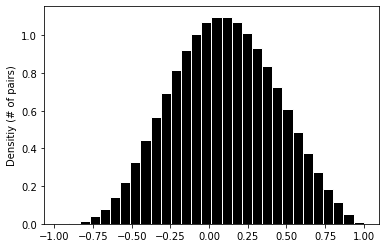

In [ ]:
%matplotlib inline
plt.hist(upper_tri_df_pair_total, density=True, bins=30, color = 'black', edgecolor = 'white', linewidth = 1.0)
plt.ylabel("Densitiy (# of pairs)")

Text(0, 0.5, 'Densitiy (# of pairs)')

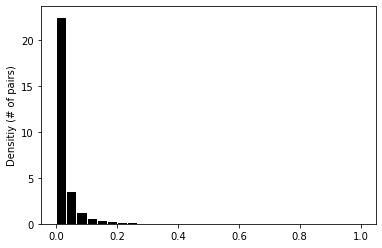

In [ ]:
plt.hist(upper_tri_df_pair_2000_total, density=True, bins=30, color = 'black', edgecolor = 'white', linewidth = 1.0)
plt.ylabel("Densitiy (# of pairs)")

# interpretation

In [ ]:
topictable

,company,best_topic,best_topic_percentage,topic_percentages
0,0,4.0,0.7421,"[(1, 0.020066058), (4, 0.74214673), (8, 0.2355..."
1,1,4.0,0.7633,"[(1, 0.035458595), (4, 0.7632646), (8, 0.18432..."
2,2,4.0,0.7772,"[(1, 0.040652473), (4, 0.7771853), (8, 0.16364..."
3,3,11.0,0.8332,"[(7, 0.1616146), (11, 0.8332092)]"
4,4,11.0,0.8174,"[(7, 0.1766861), (11, 0.8174035)]"
...,...,...,...,...
15406,15406,8.0,0.8854,"[(1, 0.03454692), (4, 0.040819917), (8, 0.8853..."
15407,15407,8.0,0.8854,"[(1, 0.03455151), (4, 0.04080596), (8, 0.88537..."
15408,15408,8.0,0.8951,"[(1, 0.040206563), (4, 0.022556778), (8, 0.895..."
15409,15409,9.0,0.8912,"[(4, 0.10782436), (9, 0.8911703)]"


In [ ]:
pd.DataFrame(topics)[1].to_csv()

',1\n0,"0.034*""truck"" + 0.029*""aircraft"" + 0.028*""fleet"" + 0.027*""dealer"" + 0.026*""vessel"" + 0.024*""engine"" + 0.020*""airline"" + 0.017*""car"" + 0.017*""motor"" + 0.015*""logistics"" + 0.013*""ship"" + 0.013*""driver"" + 0.013*""container"" + 0.012*""passenger"" + 0.012*""freight"""\n1,"0.073*""hotel"" + 0.068*""restaurant"" + 0.029*""resort"" + 0.028*""beverage"" + 0.028*""franchise"" + 0.023*""travel"" + 0.022*""ingredient"" + 0.022*""vacation"" + 0.020*""guest"" + 0.018*""park"" + 0.012*""crop"" + 0.012*""club"" + 0.010*""farm"" + 0.010*""farmer"" + 0.009*""menu"""\n2,"0.075*""trial"" + 0.065*""patient"" + 0.054*""fda"" + 0.028*""candidate"" + 0.025*""disease"" + 0.020*""therapy"" + 0.016*""indication"" + 0.014*""efficacy"" + 0.010*""commercialization"" + 0.010*""formulation"" + 0.010*""nda"" + 0.010*""exclusivity"" + 0.010*""collaboration"" + 0.008*""milestone"" + 0.008*""submission"""\n3,"0.060*""patient"" + 0.058*""hospital"" + 0.037*""medicare"" + 0.034*""physician"

In [ ]:
for topic in topics:
    print(topic)

(0, '0.034*"truck" + 0.029*"aircraft" + 0.028*"fleet" + 0.027*"dealer" + 0.026*"vessel" + 0.024*"engine" + 0.020*"airline" + 0.017*"car" + 0.017*"motor" + 0.015*"logistics" + 0.013*"ship" + 0.013*"driver" + 0.013*"container" + 0.012*"passenger" + 0.012*"freight"')
(1, '0.073*"hotel" + 0.068*"restaurant" + 0.029*"resort" + 0.028*"beverage" + 0.028*"franchise" + 0.023*"travel" + 0.022*"ingredient" + 0.022*"vacation" + 0.020*"guest" + 0.018*"park" + 0.012*"crop" + 0.012*"club" + 0.010*"farm" + 0.010*"farmer" + 0.009*"menu"')
(2, '0.075*"trial" + 0.065*"patient" + 0.054*"fda" + 0.028*"candidate" + 0.025*"disease" + 0.020*"therapy" + 0.016*"indication" + 0.014*"efficacy" + 0.010*"commercialization" + 0.010*"formulation" + 0.010*"nda" + 0.010*"exclusivity" + 0.010*"collaboration" + 0.008*"milestone" + 0.008*"submission"')
(3, '0.060*"patient" + 0.058*"hospital" + 0.037*"medicare" + 0.034*"physician" + 0.020*"medicaid" + 0.016*"therapy" + 0.015*"surgery" + 0.014*"clearance" + 0.013*"cm" + 0.0

In [ ]:
interpret_df=no_group
pd.DataFrame(interpret_df['ff12_cate'].value_counts())

,ff12_cate
Money Finance FF12,3453
Others FF12,2980
Business equipment FF12,2236
"Healthcare, medical, drugs FF12",1937
Manufacturing FF12,1134
Shops Wholesale (Retail) FF12,1126
Energy FF12,614
Consumer Non Durable FF12,556
Utilities FF12,406
Telecom FF12,352


In [ ]:
pd.DataFrame(interpret_df['sic_cate'].value_counts())

,sic_cate
Manufacturing SIC,5170
"Finance, Insurance and Real Estate SIC",3453
Services SIC,2236
Nonclassifiable SIC,1389
"Transportation, Communications, Electric, Gas and Stationary service SIC",1157
Retail Trade SIC,743
Mining SIC,704
Wholesale Trade SIC,354
Construction SIC,161
"Agriculture, Foresty and Fishing SIC",44


In [ ]:
pd.DataFrame(interpret_df['naics_cate'].value_counts())

,naics_cate
Manufacturing NAICS,5090
Finance and Insurance NAICS,2642
Nonclassifiable NAICS,1443
Information NAICS,1380
Real Estate and Rental and Leasing NAICS,849
"Mining, Quarrying, and Oil and Gas Extraction NAICS",702
Retail Trade NAICS,548
"Professional, Scientific, and Technical Services NAICS",507
Utilities NAICS,392
Wholesale Trade NAICS,356


In [ ]:
pd.DataFrame(interpret_df['gind_cate'].value_counts())

,gind_cate
Financials GIND,2631
Information Technology GIND,2199
Health Care GIND,2148
Consumer Discretionary GIND,1921
Industrials GIND,1780
Others GIND,1396
Energy GIND,932
Real Estate GIND,678
Materials GIND,652
Consumer Staples GIND,535


In [ ]:
table10=interpret_df[['company','fyear','sic','spe_kmeans','lda_cluster','ff12_cate',	'sic_cate','gind_cate']]
table10_2015=table10[table10['fyear']==2015]
table10_2015

,company,fyear,sic,spe_kmeans,lda_cluster,ff12_cate,sic_cate,gind_cate
2,1-800-FLOWERS.COM,2015,5961.0,0,4.0,Shops Wholesale (Retail) FF12,Retail Trade SIC,Consumer Discretionary GIND
4,1347 PROPERTY INS HLDGS INC,2015,6331.0,9,11.0,Money Finance FF12,"Finance, Insurance and Real Estate SIC",Financials GIND
8,180 DEGREE CPTL CORP,2015,6797.0,10,11.0,Money Finance FF12,"Finance, Insurance and Real Estate SIC",Financials GIND
12,1ST CONSTITUTION BANCORP,2015,6020.0,2,10.0,Money Finance FF12,"Finance, Insurance and Real Estate SIC",Financials GIND
16,1ST SOURCE CORP,2015,6020.0,2,10.0,Money Finance FF12,"Finance, Insurance and Real Estate SIC",Financials GIND
...,...,...,...,...,...,...,...,...
15387,ZOSANO PHARMA CORP,2015,2834.0,7,2.0,"Healthcare, medical, drugs FF12",Manufacturing SIC,Health Care GIND
15394,ZUMIEZ INC,2015,5651.0,0,4.0,Shops Wholesale (Retail) FF12,Retail Trade SIC,Consumer Discretionary GIND
15399,ZYNEX INC,2015,3845.0,11,3.0,"Healthcare, medical, drugs FF12",Manufacturing SIC,Health Care GIND
15403,ZYNGA INC,2015,7372.0,0,4.0,Business equipment FF12,Services SIC,Information Technology GIND


In [ ]:
table10_2015['gind_cate'].value_counts().to_csv()

',gind_cate\nFinancials GIND,614\nHealth Care GIND,556\nInformation Technology GIND,504\nConsumer Discretionary GIND,436\nIndustrials GIND,418\nOthers GIND,234\nEnergy GIND,202\nReal Estate GIND,179\nMaterials GIND,139\nConsumer Staples GIND,128\nUtilities GIND,96\nCommunication Services GIND,33\n'

## cluster 1

In [ ]:
cluster1=lda_df[lda_df['lda_cluster']==1]
cluster1

,company,sic,lda_cluster,spe_kmeans
257,AEGEA INC,NaN,1.0,10
332,AGILYSYS INC,7372.0,1.0,4
333,AGILYSYS INC,7372.0,1.0,4
334,AGILYSYS INC,7372.0,1.0,4
342,AGRITECH WORLDWIDE INC,2090.0,1.0,10
...,...,...,...,...
15318,Yanglin Soybean Inc,NaN,1.0,8
15319,Yongye International Inc,NaN,1.0,6
15320,Yongye International Inc,NaN,1.0,6
15375,ZOE'S KITCHEN INC,5812.0,1.0,10


In [ ]:
# 'HILTON WORLDWIDE HOLDINGS','HYATT HOTELS CORP','TRIPADVISOR INC','MARRIOTT INTL INC', 'MARRIOTT VACATIONS WORLDWIDE','MGM RESORTS INTERNATIONAL'
cluster1['company'].unique()

In [ ]:
hotels=['HILTON WORLDWIDE HOLDINGS','HYATT HOTELS CORP','MARRIOTT INTL INC',
        'MARRIOTT VACATIONS WORLDWIDE','MGM RESORTS INTERNATIONAL',
        'XENIA HOTELS & RESORTS INC','CHOICE HOTELS INTL INC','PEAK RESORTS INC', 
        'PEBBLEBROOK HOTEL TRUST','STRATEGIC HOTELS & RESORTS']
resturants=["ZOE'S KITCHEN INC",'YUM BRANDS INC','PAPA JOHNS INTERNATIONAL INC',
        'DEAN FOODS CO','FRISCHS RESTAURANTS INC',
        'DARDEN RESTAURANTS INC','DEL TACO RESTAURANTS INC','DIVERSIFIED RESTAURANT HLDGS']
print(len(hotels))

10


In [ ]:
cluster1=table10_2015[table10_2015['lda_cluster']==1]
cluster1['gind_cate'].value_counts()

Consumer Discretionary GIND    81
Consumer Staples GIND          43
Real Estate GIND               28
Others GIND                     8
Materials GIND                  6
Information Technology GIND     5
Industrials GIND                4
Health Care GIND                1
Financials GIND                 1
Name: gind_cate, dtype: int64

In [ ]:
table10_2015[(table10_2015['company']== hotels[0])|(table10_2015['company']== hotels[1])|
             (table10_2015['company']== hotels[2])|(table10_2015['company']== hotels[3])|
             (table10_2015['company']== hotels[4])|(table10_2015['company']== hotels[5])|
             (table10_2015['company']== hotels[6])|(table10_2015['company']== hotels[7])|
             (table10_2015['company']== hotels[8])|(table10_2015['company']== hotels[9])]

,company,fyear,sic,spe_kmeans,lda_cluster,ff12_cate,sic_cate,gind_cate
2982,CHOICE HOTELS INTL INC,2015,6794.0,10,1.0,Money Finance FF12,"Finance, Insurance and Real Estate SIC",Consumer Discretionary GIND
6728,HILTON WORLDWIDE HOLDINGS,2015,7011.0,10,1.0,Others FF12,Services SIC,Consumer Discretionary GIND
6948,HYATT HOTELS CORP,2015,7011.0,10,1.0,Others FF12,Services SIC,Consumer Discretionary GIND
8713,MARRIOTT INTL INC,2015,7011.0,10,1.0,Others FF12,Services SIC,Consumer Discretionary GIND
8717,MARRIOTT VACATIONS WORLDWIDE,2015,7011.0,10,1.0,Others FF12,Services SIC,Consumer Discretionary GIND
9071,MGM RESORTS INTERNATIONAL,2015,7990.0,10,1.0,Others FF12,Services SIC,Consumer Discretionary GIND
10675,PEAK RESORTS INC,2015,7990.0,10,1.0,Others FF12,Services SIC,Consumer Discretionary GIND
10686,PEBBLEBROOK HOTEL TRUST,2015,6798.0,10,1.0,Money Finance FF12,"Finance, Insurance and Real Estate SIC",Real Estate GIND
15225,XENIA HOTELS & RESORTS INC,2015,6798.0,10,1.0,Money Finance FF12,"Finance, Insurance and Real Estate SIC",Real Estate GIND


In [ ]:
table10_2015[(table10_2015['company']== resturants[0])|(table10_2015['company']== resturants[1])|
            (table10_2015['company']== resturants[2])|(table10_2015['company']== resturants[3])|
            (table10_2015['company']== resturants[4])|(table10_2015['company']== resturants[5])|
            (table10_2015['company']== resturants[6])|(table10_2015['company']== resturants[7])]

,company,fyear,sic,spe_kmeans,lda_cluster,ff12_cate,sic_cate,gind_cate
3925,DARDEN RESTAURANTS INC,2015,5812.0,10,1.0,Shops Wholesale (Retail) FF12,Retail Trade SIC,Consumer Discretionary GIND
3994,DEL TACO RESTAURANTS INC,2015,5812.0,10,1.0,Shops Wholesale (Retail) FF12,Retail Trade SIC,Consumer Discretionary GIND
4187,DIVERSIFIED RESTAURANT HLDGS,2015,5812.0,10,1.0,Shops Wholesale (Retail) FF12,Retail Trade SIC,Consumer Discretionary GIND
5693,FRISCHS RESTAURANTS INC,2015,NaN,10,1.0,Others FF12,Nonclassifiable SIC,Others GIND
10567,PAPA JOHNS INTERNATIONAL INC,2015,5812.0,10,1.0,Shops Wholesale (Retail) FF12,Retail Trade SIC,Consumer Discretionary GIND
15312,YUM BRANDS INC,2015,5812.0,10,1.0,Shops Wholesale (Retail) FF12,Retail Trade SIC,Consumer Discretionary GIND
15376,ZOE'S KITCHEN INC,2015,5812.0,10,1.0,Shops Wholesale (Retail) FF12,Retail Trade SIC,Consumer Discretionary GIND


## cluster 2

In [ ]:
cluster11=table10_2015[table10_2015['lda_cluster']==10]
cluster11['company'].unique()

In [ ]:
cluster11=table10_2015[table10_2015['lda_cluster']==11]
cluster11['company'].unique()

In [ ]:
cluster11[cluster11['gind_cate']=='Real Estate GIND']

,company,fyear,sic,spe_kmeans,lda_cluster,ff12_cate,sic_cate,gind_cate
104,ACADIA REALTY TRUST,2015,6798.0,10,11.0,Money Finance FF12,"Finance, Insurance and Real Estate SIC",Real Estate GIND
163,ACRE REALTY INVESTORS INC,2015,6798.0,10,11.0,Money Finance FF12,"Finance, Insurance and Real Estate SIC",Real Estate GIND
436,ALEXANDER'S INC,2015,6798.0,10,11.0,Money Finance FF12,"Finance, Insurance and Real Estate SIC",Real Estate GIND
440,ALEXANDRIA R E EQUITIES INC,2015,6798.0,10,11.0,Money Finance FF12,"Finance, Insurance and Real Estate SIC",Real Estate GIND
693,AMERICAN ASSETS TRUST INC,2015,6798.0,10,11.0,Money Finance FF12,"Finance, Insurance and Real Estate SIC",Real Estate GIND
...,...,...,...,...,...,...,...,...
14828,WASHINGTON PRIME GROUP INC,2015,6798.0,10,11.0,Money Finance FF12,"Finance, Insurance and Real Estate SIC",Real Estate GIND
14895,WEINGARTEN REALTY INVST,2015,6798.0,10,11.0,Money Finance FF12,"Finance, Insurance and Real Estate SIC",Real Estate GIND
14917,WELLTOWER INC,2015,6798.0,9,11.0,Money Finance FF12,"Finance, Insurance and Real Estate SIC",Real Estate GIND
15017,WHEELER REAL ESTATE INVT TR,2015,6798.0,10,11.0,Money Finance FF12,"Finance, Insurance and Real Estate SIC",Real Estate GIND


In [ ]:
hotels=['HILTON WORLDWIDE HOLDINGS','HYATT HOTELS CORP','MARRIOTT INTL INC',
        'MARRIOTT VACATIONS WORLDWIDE','MGM RESORTS INTERNATIONAL',
        'XENIA HOTELS & RESORTS INC','CHOICE HOTELS INTL INC','PEAK RESORTS INC', 
        'PEBBLEBROOK HOTEL TRUST','STRATEGIC HOTELS & RESORTS']
resturants=["ZOE'S KITCHEN INC",'YUM BRANDS INC','PAPA JOHNS INTERNATIONAL INC',
        'DEAN FOODS CO','FRISCHS RESTAURANTS INC',
        'DARDEN RESTAURANTS INC','DEL TACO RESTAURANTS INC','DIVERSIFIED RESTAURANT HLDGS']
print(len(hotels))

In [ ]:
table10_2015[(table10_2015['company']== hotels[0])|(table10_2015['company']== hotels[1])|
             (table10_2015['company']== hotels[2])|(table10_2015['company']== hotels[3])|
             (table10_2015['company']== hotels[4])|(table10_2015['company']== hotels[5])|
             (table10_2015['company']== hotels[6])|(table10_2015['company']== hotels[7])|
             (table10_2015['company']== hotels[8])|(table10_2015['company']== hotels[9])]

In [ ]:
table10_2015[(table10_2015['company']== resturants[0])|(table10_2015['company']== resturants[1])|
            (table10_2015['company']== resturants[2])|(table10_2015['company']== resturants[3])|
            (table10_2015['company']== resturants[4])|(table10_2015['company']== resturants[5])|
            (table10_2015['company']== resturants[6])|(table10_2015['company']== resturants[7])]

##cluster 2 3 5

In [ ]:
cluster5=table10_2015[table10_2015['lda_cluster']==5]
cluster5['gind_cate'].value_counts()

Health Care GIND               43
Consumer Discretionary GIND    19
Others GIND                     5
Information Technology GIND     2
Industrials GIND                1
Name: gind_cate, dtype: int64

In [ ]:
cluster2=table10_2015[table10_2015['lda_cluster']==2]
cluster2['gind_cate'].value_counts()

Health Care GIND         317
Others GIND               18
Consumer Staples GIND      3
Materials GIND             1
Energy GIND                1
Name: gind_cate, dtype: int64

In [ ]:
cluster3=table10_2015[table10_2015['lda_cluster']==3]
cluster3['gind_cate'].value_counts()

Health Care GIND               161
Others GIND                      9
Real Estate GIND                 7
Consumer Staples GIND            2
Information Technology GIND      2
Industrials GIND                 1
Financials GIND                  1
Name: gind_cate, dtype: int64

## cluster 4

In [ ]:
cluster4=table10_2015[table10_2015['lda_cluster']==4]
cluster4['gind_cate'].value_counts()

Consumer Discretionary GIND    194
Consumer Staples GIND           66
Industrials GIND                21
Others GIND                     15
Information Technology GIND     12
Real Estate GIND                 6
Health Care GIND                 5
Materials GIND                   2
Utilities GIND                   1
Name: gind_cate, dtype: int64

In [ ]:
cluster1=table10_2015[table10_2015['lda_cluster']==1]
cluster1['gind_cate'].value_counts()

Consumer Discretionary GIND    81
Consumer Staples GIND          43
Real Estate GIND               28
Others GIND                     8
Materials GIND                  6
Information Technology GIND     5
Industrials GIND                4
Health Care GIND                1
Financials GIND                 1
Name: gind_cate, dtype: int64

In [ ]:
cluster4

,company,fyear,sic,spe_kmeans,lda_cluster,ff12_cate,sic_cate,gind_cate
2,1-800-FLOWERS.COM,2015,5961.0,0,4.0,Shops Wholesale (Retail) FF12,Retail Trade SIC,Consumer Discretionary GIND
51,A V HOMES INC,2015,1531.0,10,4.0,Others FF12,Construction SIC,Consumer Discretionary GIND
66,AARON'S INC,2015,7359.0,0,4.0,Others FF12,Services SIC,Consumer Discretionary GIND
80,ABERCROMBIE & FITCH -CL A,2015,5651.0,0,4.0,Shops Wholesale (Retail) FF12,Retail Trade SIC,Consumer Discretionary GIND
123,ACCO BRANDS CORP,2015,2780.0,0,4.0,Consumer Non Durable FF12,Manufacturing SIC,Industrials GIND
...,...,...,...,...,...,...,...,...
15198,WYNN RESORTS LTD,2015,7990.0,10,4.0,Others FF12,Services SIC,Consumer Discretionary GIND
15217,XCEL BRANDS INC,2015,6794.0,0,4.0,Money Finance FF12,"Finance, Insurance and Real Estate SIC",Consumer Discretionary GIND
15300,YOUNGEVITY INTERNATIONAL INC,2015,2834.0,0,4.0,"Healthcare, medical, drugs FF12",Manufacturing SIC,Consumer Staples GIND
15394,ZUMIEZ INC,2015,5651.0,0,4.0,Shops Wholesale (Retail) FF12,Retail Trade SIC,Consumer Discretionary GIND
